> **Problem overview**

In 2018, air pollution in the Thai capital has come under increasing scrutiny with residents complaining of smog and respiratory problems. Some schools were closed or kept children indoors. The Pollution Control Department reported PM2.5 dust in the Bangkok Metropolitan at midday on Feb 8, 2018 and at midday it was measured at 72-95 micrograms per cubic metre, with the likelihood that it would increase.

In 2019, Bangkok is placed in the world’s top 10 cities with the worst air quality, Greenpeace Thailand was quoting the US air quality index measuring pollution floating around in the air we breathe. On Jan 30, 2019, the Pollution Control Department reported that levels of PM2.5 ranged from 59-142 micrograms per cubic metre of air during the past 24 hours, breaching the 50 micrograms per cubic metre.

In this challenge, the Bangkok air pollution dataset is referred to "berkeleyearth" and weather report dataset is referred to "wunderground" at weather station closed to Patumwan demonstration school.

Link:
* http://air4thai.pcd.go.th/webV2/
* http://www.aqmthai.com/public_report.php
* http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/Bangkok/Bangkok.txt
* https://www.wunderground.com/personal-weather-station/dashboard?ID=IBANGKOK26

In [1]:
# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import scientific computing library
import scipy

# import sklearn data preprocessing
from sklearn.preprocessing import RobustScaler

# import sklearn model class
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring berkeleyearth and wunderground data
df_aqmthai = pd.read_csv('../input/aqmthai.csv')
df_berkeleyearth = pd.read_csv('../input/berkeleyearth.csv')
df_stationcoordinate = pd.read_csv('../input/station_coordinate.csv')
df_wunderground = pd.read_csv('../input/wunderground.csv', parse_dates=['date'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,2,7,8,11,18,21,22,25,27,29,31,33,34,36,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# visualize head of the aqmthai data
df_aqmthai.head(n=5)

at (c) ben (ug/m3) bp (mbar)   ...   mpxy (ug/m3) oxyl (ug/m3) station
0     NaN         NaN       NaN   ...            NaN          NaN     02t
1     NaN         NaN       NaN   ...            NaN          NaN     02t
2     NaN         NaN       NaN   ...            NaN          NaN     02t
3     NaN         NaN       NaN   ...            NaN          NaN     02t
4     NaN         NaN       NaN   ...            NaN          NaN     02t

[5 rows x 42 columns]

In [4]:
# visualize head of the berkeleyearth data
df_berkeleyearth.head(n=5)

year  month  day  utc_hour  pm2.5  pm10_mask  retrospective
0  2016      3    3         8   62.9          1              0
1  2016      3    3         9   62.9          1              0
2  2016      3    3        10   55.5          1              0
3  2016      3    3        11   55.5          1              0
4  2016      3    3        12   47.9          1              0

In [5]:
# visualize tail of the station coordinate data
df_stationcoordinate.tail(n=5)

lastupdate.aqi.level  lastupdate.aqi.aqi     ...     stationid stationtype
59                     1                  11     ...          m101      MOBILE
60                     1                  22     ...          m114      MOBILE
61                     4                 144     ...           72t      GROUND
62                     4                 172     ...           69t      GROUND
63                     2                  48     ...           58t      GROUND

[5 rows x 24 columns]

In [6]:
# visualize tail of the wunderground data
df_wunderground.tail(n=5)

date      time temperature   ...   precip_accum uv   solar
274533 2019-01-31  11:35 PM     28.1 °C   ...           0 mm  0  0 w/m²
274534 2019-01-31  11:40 PM     28.1 °C   ...           0 mm  0  0 w/m²
274535 2019-01-31  11:45 PM     28.1 °C   ...           0 mm  0  0 w/m²
274536 2019-01-31  11:50 PM     28.1 °C   ...           0 mm  0  0 w/m²
274537 2019-01-31  11:55 PM     28.1 °C   ...           0 mm  0  0 w/m²

[5 rows x 13 columns]

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [7]:
def boxplot(categorical_x: list or str, numerical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a box plot applied for categorical variable in x-axis vs numerical variable in y-axis.
    
    Args:
        categorical_x (list or str): The categorical variable in x-axis.
        numerical_y (list or str): The numerical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    categorical_x, numerical_y = [categorical_x] if type(categorical_x) == str else categorical_x, [numerical_y] if type(numerical_y) == str else numerical_y
    if nrows is None: nrows = (len(categorical_x)*len(numerical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.boxplot(x=vj, y=vi, data=data, ax=axes[i*len(categorical_x) + j]) for i, vi in enumerate(numerical_y) for j, vj in enumerate(categorical_x)]
    return fig

In [8]:
def violinplot(categorical_x: list or str, numerical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a violin plot applied for categorical variable in x-axis vs numerical variable in y-axis.
    
    Args:
        categorical_x (list or str): The categorical variable in x-axis.
        numerical_y (list or str): The numerical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    categorical_x, numerical_y = [categorical_x] if type(categorical_x) == str else categorical_x, [numerical_y] if type(numerical_y) == str else numerical_y
    if nrows is None: nrows = (len(categorical_x)*len(numerical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.violinplot(x=vj, y=vi, data=data, ax=axes[i*len(categorical_x) + j], rasterized=True) for i, vi in enumerate(numerical_y) for j, vj in enumerate(categorical_x)]
    return fig

In [9]:
def scatterplot(numerical_x: list or str, numerical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a scatter plot applied for numerical variable in x-axis vs numerical variable in y-axis.
    
    Args:
        numerical_x (list or str): The numerical variable in x-axis.
        numerical_y (list or str): The numerical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    numerical_x, numerical_y = [numerical_x] if type(numerical_x) == str else numerical_x, [numerical_y] if type(numerical_y) == str else numerical_y
    if nrows is None: nrows = (len(numerical_x)*len(numerical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.scatterplot(x=vj, y=vi, data=data, ax=axes[i*len(numerical_x) + j], rasterized=True) for i, vi in enumerate(numerical_y) for j, vj in enumerate(numerical_x)]
    return fig

In [10]:
# feature extraction: datetime
df_aqmthai['datetime'] = pd.to_datetime(df_aqmthai['date'].astype(str), format='%m/%d/%Y %H:%M')

In [11]:
# feature extraction: pm10
df_aqmthai['pm10 (ug/m3)'] = df_aqmthai['pm10 (ug/m3)'].apply(lambda x: np.nan if x == '-' else x).astype(float)

In [12]:
# feature extraction: pm2.5
df_aqmthai['pm2.5 (ug/m3)'] = df_aqmthai['pm2.5 (ug/m3)'].apply(lambda x: np.nan if x == '-' else x).astype(float)

In [13]:
# feature exploration: bangkok station
bkk_stations = ['03t', '05t', '10t', '11t', '50t', '52t', '53t', '54t', '59t' ,'61t']
df_stationcoordinate.loc[df_stationcoordinate['stationid'].isin(bkk_stations), ['stationid', 'areath']]

stationid                                      areath
0       03t  ริมถนนกาญจนาภิเษก เขตบางขุนเทียน, กรุงเทพฯ
1       05t               แขวงบางนา, เขตบางนา, กรุงเทพฯ
2       10t          แขวงคลองจั่น, เขตบางกะปิ, กรุงเทพฯ
3       11t             แขวงดินแดง, เขตดินแดง, กรุงเทพฯ
4       50t         ริมถนนพระราม 4 เขตปทุมวัน, กรุงเทพฯ
5       52t      ริมถนนอินทรพิทักษ์ เขตธนบุรี, กรุงเทพฯ
6       53t      ริมถนนลาดพร้าว เขตวังทองหลาง, กรุงเทพฯ
7       54t            ริมถนนดินแดง เขตดินแดง, กรุงเทพฯ
8       59t               แขวงพญาไท, เขตพญาไท, กรุงเทพฯ
9       61t        แขวงพลับพลา, เขตวังทองหลาง, กรุงเทพฯ

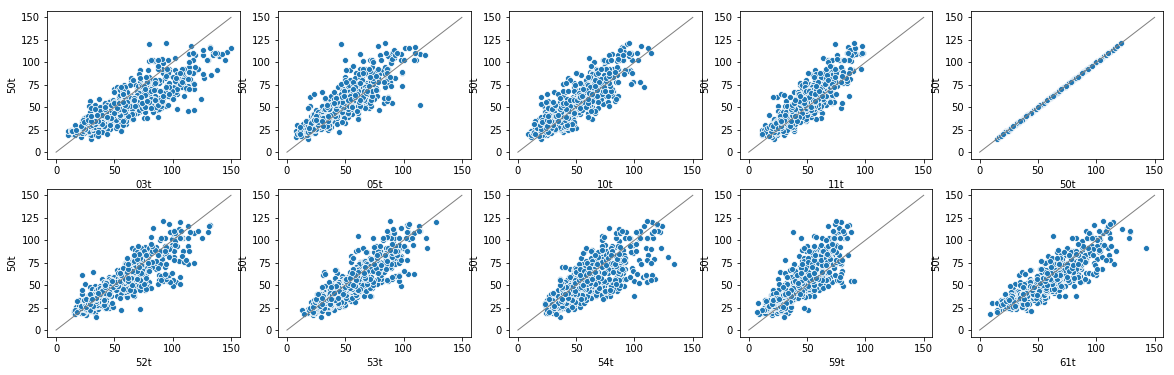

In [14]:
# feature exploration: pm2.5 in each bangkok station
p = pd.pivot_table(df_aqmthai[['datetime', 'pm10 (ug/m3)', 'pm2.5 (ug/m3)', 'station']], values=['pm10 (ug/m3)', 'pm2.5 (ug/m3)'], index=['datetime'], columns=['station'], aggfunc=np.mean)
fig, axes = plt.subplots(figsize=(20 , 3*(len(bkk_stations) - 1) // 5 + 1), ncols=5, nrows=(len(bkk_stations) - 1) // 5 + 1)
axes = axes.flatten()
for i, xi in enumerate(bkk_stations):
    _ = sns.scatterplot(x=xi, y='50t', data=p['pm2.5 (ug/m3)'], ax=axes[i])
    _ = axes[i].plot([0, 150], [0, 150], color='grey', linewidth=1)

In [15]:
# feature extraction: date and datetime
df_berkeleyearth['date'] = pd.to_datetime(df_berkeleyearth[['year', 'month', 'day']])
df_berkeleyearth['datetime'] = pd.to_datetime(df_berkeleyearth['date'] + df_berkeleyearth['utc_hour'].astype('timedelta64[h]'))

In [16]:
# feature extraction: datetime
df_wunderground['datetime'] = pd.to_datetime(df_wunderground['date'].astype(str) + ' ' + df_wunderground['time'].astype(str).apply(lambda x: x[:x.find(':')] + ':00 ' + x[-2:]), format='%Y-%m-%d %I:%M %p')

In [17]:
# feature extraction: temperature
df_wunderground['temperature'] = df_wunderground['temperature'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' °C', '')).astype(float)

In [18]:
# feature extraction: dew_point
df_wunderground['dew_point'] = df_wunderground['dew_point'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' °C', '')).astype(float)

In [19]:
# feature extraction: humidity
df_wunderground['humidity'] = df_wunderground['humidity'].apply(lambda x: np.nan if x == '-- %' else x.replace('%', '')).astype(float)

In [20]:
# feature extraction: wind
df_wunderground['wind'] = df_wunderground['wind'].apply(lambda x: np.nan if x == '--' else x)
df_wunderground = pd.get_dummies(df_wunderground, columns=['wind'], drop_first=False)

In [21]:
# feature extraction: speed
df_wunderground['speed'] = df_wunderground['speed'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' kph', '')).astype(float)

In [22]:
# feature extraction: gust
df_wunderground['gust'] = df_wunderground['gust'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' kph', '')).astype(float)

In [23]:
# feature extraction: pressure
df_wunderground['pressure'] = df_wunderground['pressure'].apply(lambda x: x.replace(' hPa', '')).astype(float)

In [24]:
# feature extraction: precip_rate
df_wunderground['precip_rate'] = df_wunderground['precip_rate'].apply(lambda x: x.replace(' mm', '')).astype(float)

In [25]:
# feature extraction: precip_accum
df_wunderground['precip_accum'] = df_wunderground['precip_accum'].apply(lambda x: x.replace(' mm', '')).astype(float)

In [26]:
# feature extraction: uv
df_wunderground['uv'] = df_wunderground['uv'].apply(lambda x: np.nan if x == '--' else x).astype(float)

In [27]:
# feature extraction: solar
df_wunderground['solar'] = df_wunderground['solar'].apply(lambda x: np.nan if x == '#NAME?' else x.replace(' w/m²', '')).astype(float)

In [28]:
# feature extraction: fillna with ffill
col_fillnas = ['temperature', 'dew_point', 'humidity', 'speed', 'gust', 'pressure', 'precip_rate', 'precip_accum', 'uv', 'solar']
df_wunderground[col_fillnas] = df_wunderground[col_fillnas].fillna(method='ffill')

In [29]:
# feature extraction: fillna with 0
col_fillnas = ['wind_ENE', 'wind_ESE', 'wind_East', 'wind_NE', 'wind_NNE', 'wind_NNW', 'wind_NW', 'wind_North', 'wind_SE', 'wind_SSE', 'wind_SSW', 'wind_SW', 'wind_South', 'wind_WNW', 'wind_WSW', 'wind_West']
df_wunderground[col_fillnas] = df_wunderground[col_fillnas].fillna(0)

In [30]:
# feature extraction: wunderground_datetime dataframe
df_wunderground_datetime = df_wunderground.groupby(['datetime'], as_index=False).agg({
    'temperature': 'mean', 'dew_point': 'mean', 'humidity': 'mean', 'speed': 'mean', 'gust': 'mean',
    'pressure': 'mean', 'precip_rate': sum, 'precip_accum': sum, 'uv': 'mean', 'solar': 'mean',
    'wind_East': sum, 'wind_ENE': sum, 'wind_ESE': sum,
    'wind_North': sum, 'wind_NE': sum, 'wind_NNE': sum, 'wind_NNW': sum, 'wind_NW': sum,
    'wind_South': sum, 'wind_SE': sum, 'wind_SSE': sum, 'wind_SSW': sum, 'wind_SW': sum,
    'wind_West': sum, 'wind_WNW': sum, 'wind_WSW': sum
})

# feature extraction: data dataframe
df_data = pd.merge(df_berkeleyearth[['datetime', 'year', 'month', 'day', 'utc_hour', 'pm2.5', 'pm10_mask', 'retrospective']],
                   df_wunderground_datetime, how='left', left_on='datetime', right_on='datetime').rename(columns={'utc_hour': 'hour'})
df_data = df_data.set_index('datetime')

# feature extraction: combination of keyword date
df_data.insert(4, 'dayofweek', df_data.index.dayofweek)
df_data.insert(5, 'dayofyear', df_data.index.dayofyear)

In [31]:
# feature extraction: wind direction
col_winddirs = ['wind_ENE', 'wind_ESE', 'wind_East', 'wind_NE', 'wind_NNE', 'wind_NNW', 'wind_NW', 'wind_North', 'wind_SE', 'wind_SSE', 'wind_SSW', 'wind_SW', 'wind_South', 'wind_WNW', 'wind_WSW', 'wind_West']
for col_winddir in col_winddirs: df_data[col_winddir] = df_data[col_winddir].apply(lambda x: 0 if x == 0 else 1)

In [32]:
# describe data dataframe
df_data.describe(include='all')

year         month      ...           wind_WNW      wind_WSW
count  23549.000000  23549.000000      ...       23549.000000  23549.000000
mean    2017.105355      6.704064      ...           0.347233      0.549195
std        0.856971      3.380332      ...           0.476101      0.497585
min     2016.000000      1.000000      ...           0.000000      0.000000
25%     2016.000000      4.000000      ...           0.000000      0.000000
50%     2017.000000      7.000000      ...           0.000000      1.000000
75%     2018.000000     10.000000      ...           1.000000      1.000000
max     2019.000000     12.000000      ...           1.000000      1.000000

[8 rows x 35 columns]

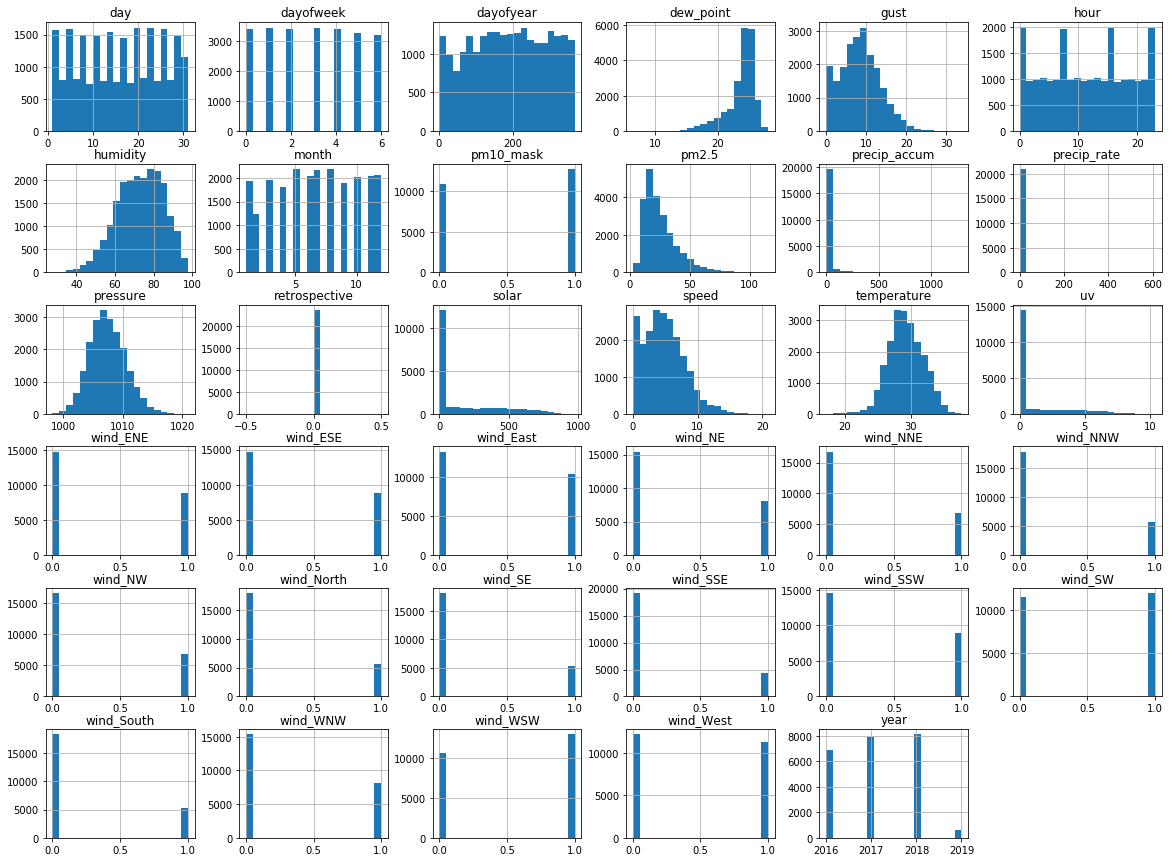

In [33]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(20, 15))

In [34]:
# convert dtypes numeric to object
col_convert = ['wind_ENE', 'wind_ESE', 'wind_East', 'wind_NE', 'wind_NNE', 'wind_NNW', 'wind_NW', 'wind_North', 'wind_SE', 'wind_SSE', 'wind_SSW', 'wind_SW', 'wind_South', 'wind_WNW', 'wind_WSW', 'wind_West']
df_data[col_convert] = df_data[col_convert].astype('object')

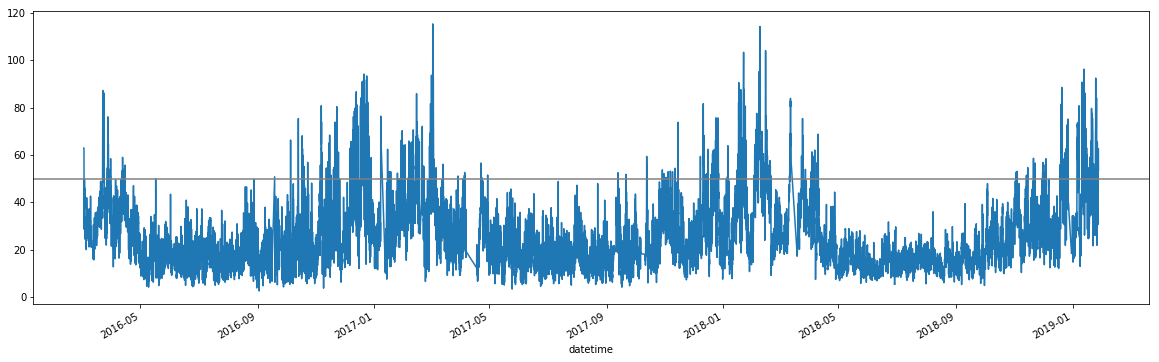

In [35]:
# feature exploration: season pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = df_data['pm2.5'].plot()
_ = plt.axhline(50, color="grey")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


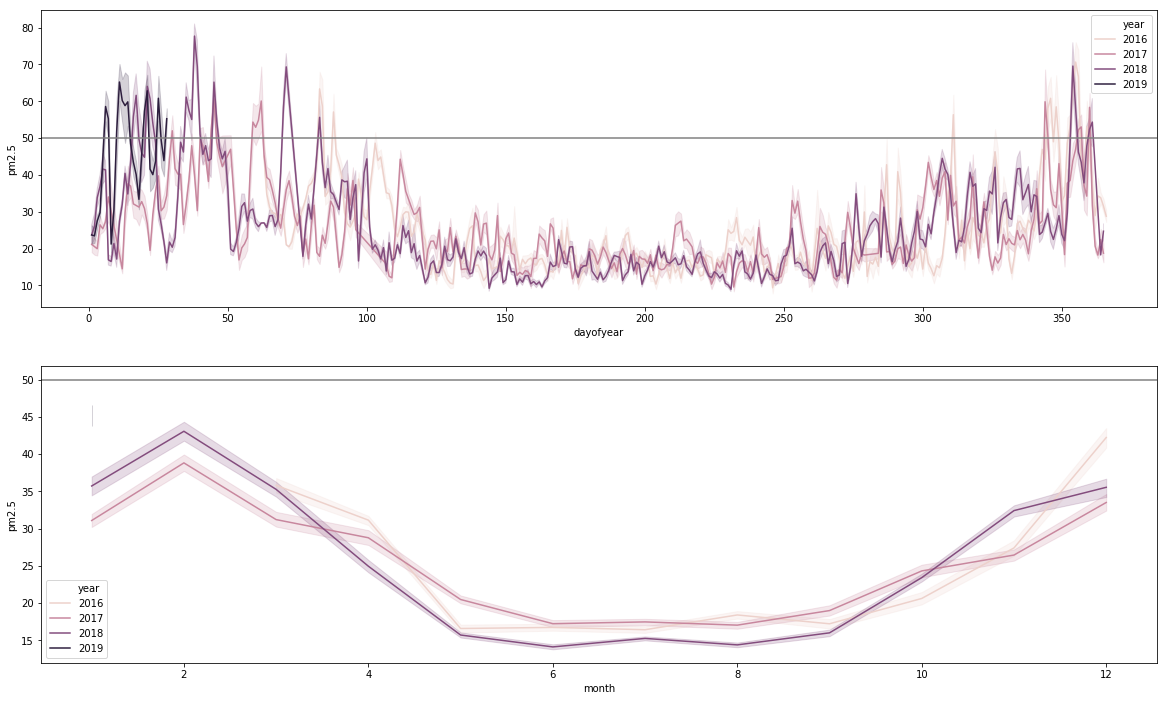

In [36]:
# feature exploration: season pm2.5
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='pm2.5', data=df_data, ax=axes[0], hue='year')
_ = axes[0].axhline(50, color="grey")
_ = sns.lineplot(x='month', y='pm2.5', data=df_data, ax=axes[1], hue='year')
_ = axes[1].axhline(50, color="grey")

The exploratory data analysis resulting in,

* **Year:** The PM2.5 tend to behave the similar trend between year.
* **Month:** The PM2.5 tend to correlate with the month/season in each year.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


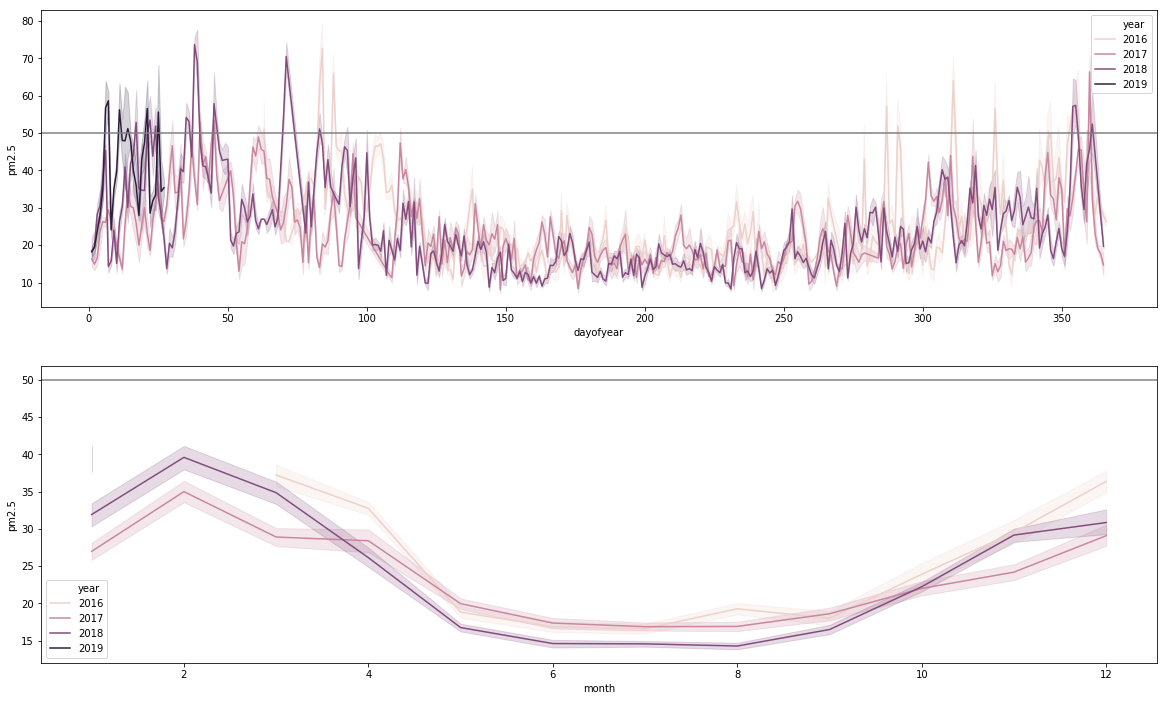

In [37]:
# feature exploration: season pm2.5 between 4 am to 2 pm
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='pm2.5', data=df_data[(df_data['hour'] >= 4) & (df_data['hour'] <= 14)], ax=axes[0], hue='year')
_ = axes[0].axhline(50, color="grey")
_ = sns.lineplot(x='month', y='pm2.5', data=df_data[(df_data['hour'] >= 4) & (df_data['hour'] <= 14)], ax=axes[1], hue='year')
_ = axes[1].axhline(50, color="grey")

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


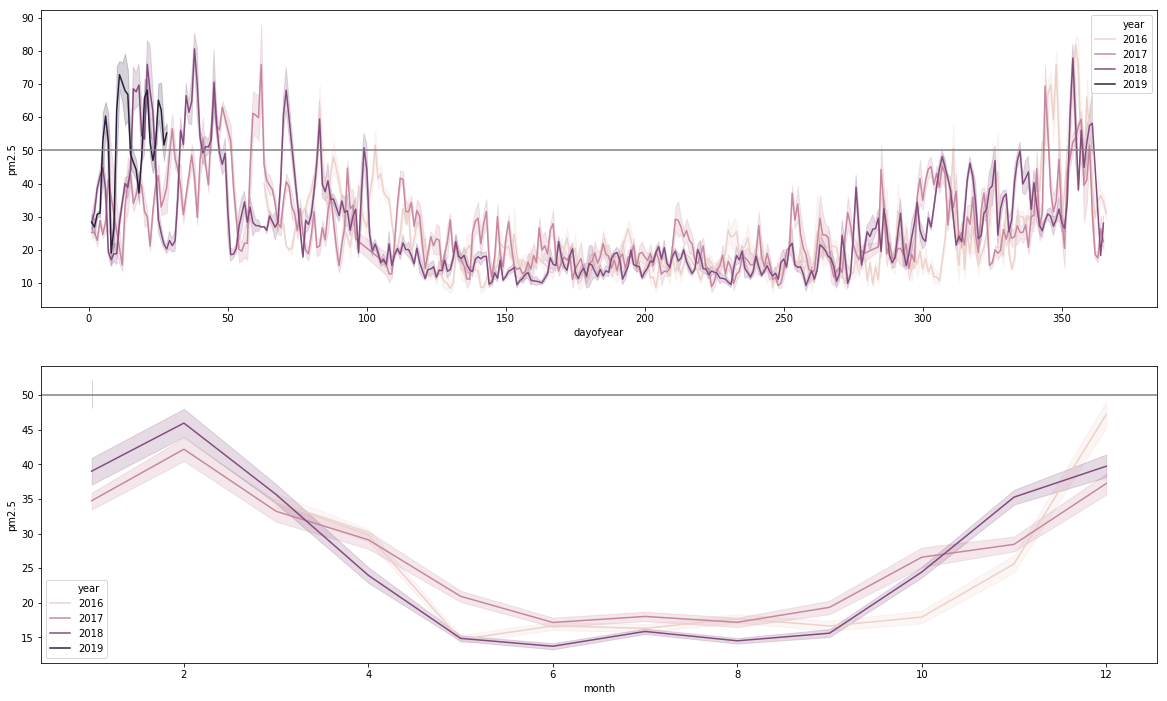

In [38]:
# feature exploration: season pm2.5 before 4 am and after 2 pm
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='pm2.5', data=df_data[(df_data['hour'] < 4) | (df_data['hour'] > 14)], ax=axes[0], hue='year')
_ = axes[0].axhline(50, color="grey")
_ = sns.lineplot(x='month', y='pm2.5', data=df_data[(df_data['hour'] < 4) | (df_data['hour'] > 14)], ax=axes[1], hue='year')
_ = axes[1].axhline(50, color="grey")

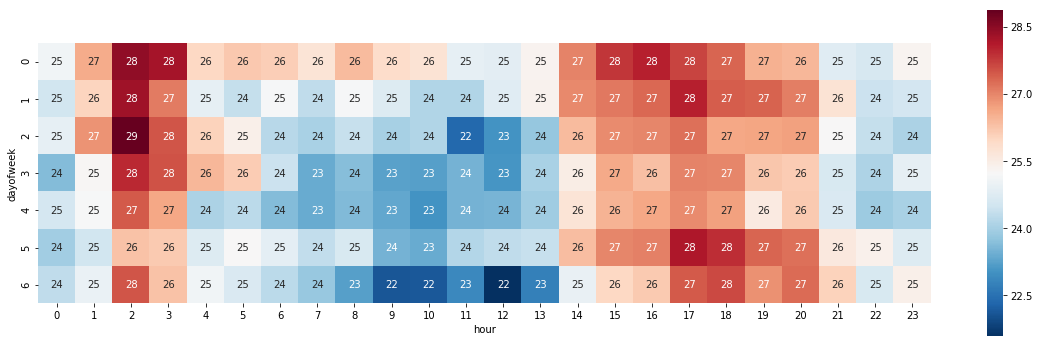

In [39]:
# feature exploration: dayofweek-hour pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
p = pd.pivot_table(df_data, values='pm2.5', index=['dayofweek'], columns=['hour'], aggfunc=np.mean)
_ = sns.heatmap(p, annot=True, cmap=plt.cm.RdBu_r, fmt='.0f', square=True)

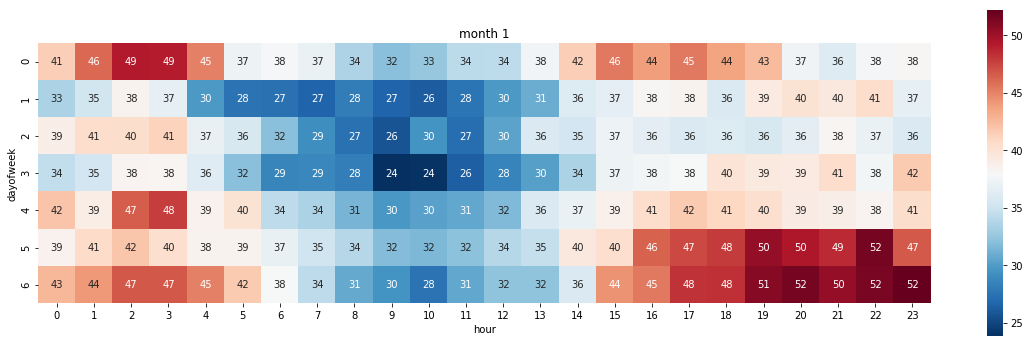

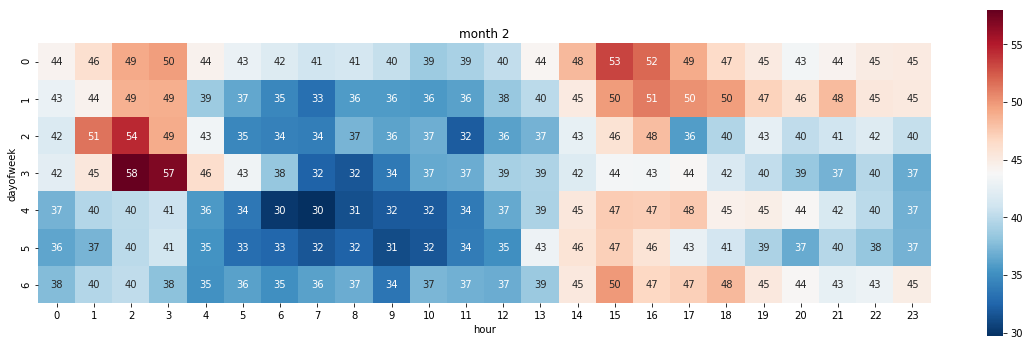

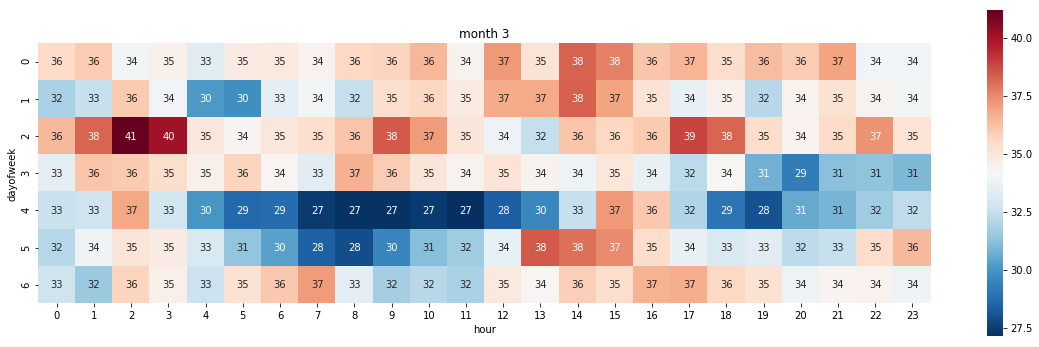

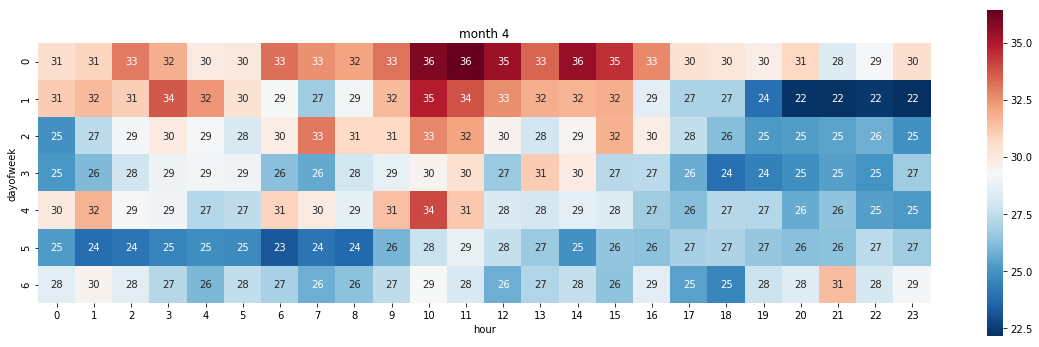

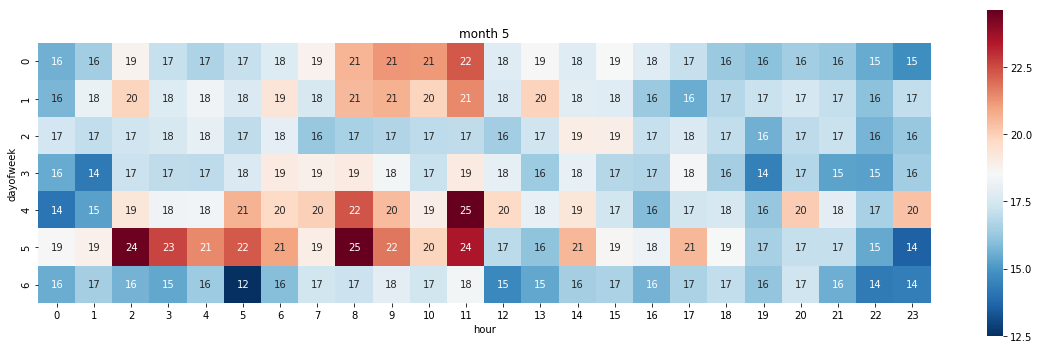

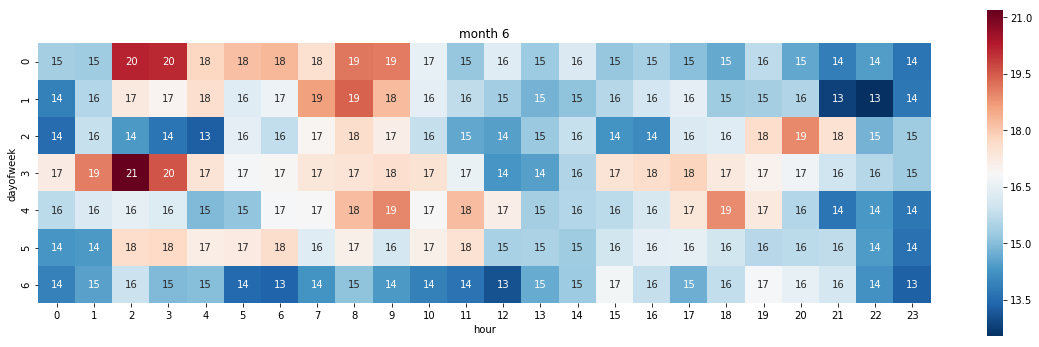

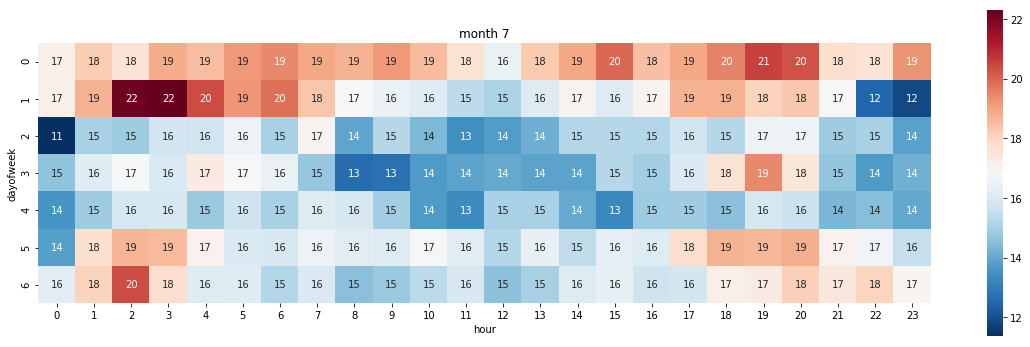

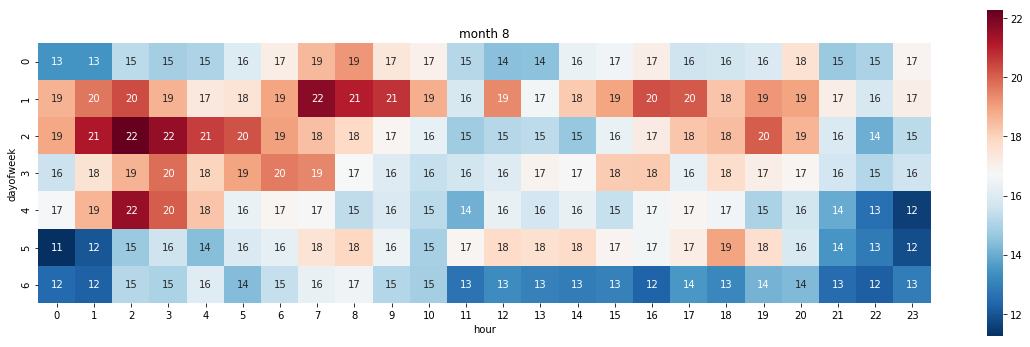

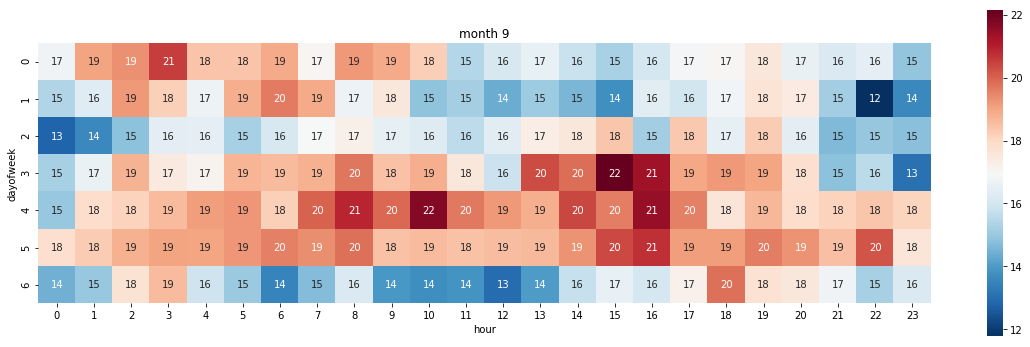

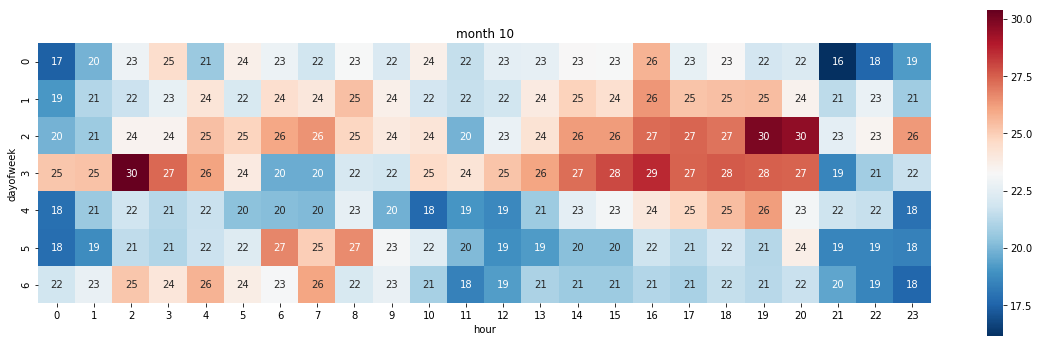

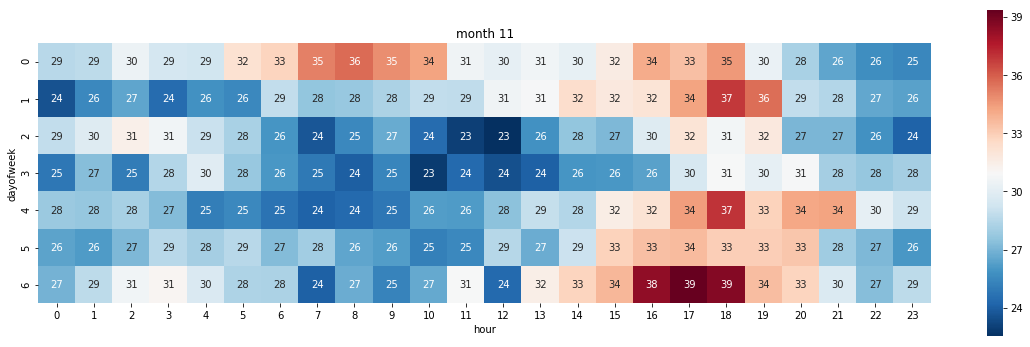

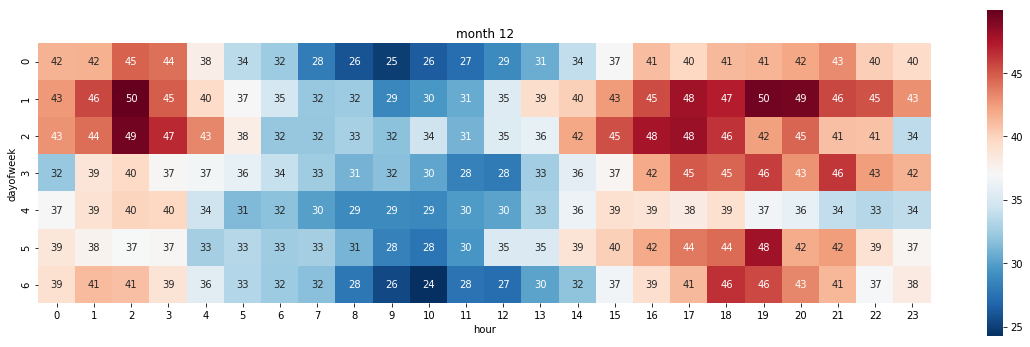

In [40]:
# feature exploration: month-dayofweek-hour pm2.5
for m in range(1, 13):
    fig, axes = plt.subplots(figsize=(20, 6))
    p = pd.pivot_table(df_data.loc[df_data['month'] == m], values='pm2.5', index=['dayofweek'], columns=['hour'], aggfunc=np.mean)
    _ = sns.heatmap(p, annot=True, cmap=plt.cm.RdBu_r, fmt='.0f', square=True)
    axes.set_title('month %d' %m)

The exploratory data analysis resulting in,

* **Hour:** During December to March in each year, the PM2.5 tend to be lower during the day-time and higher during the night time.
* **DayofWeek:** The PM2.5 tend to be higher during Sunday to Monday and lower during Tuesday to Friday.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


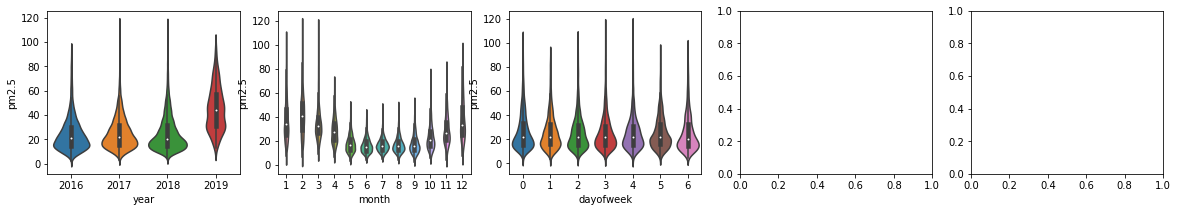

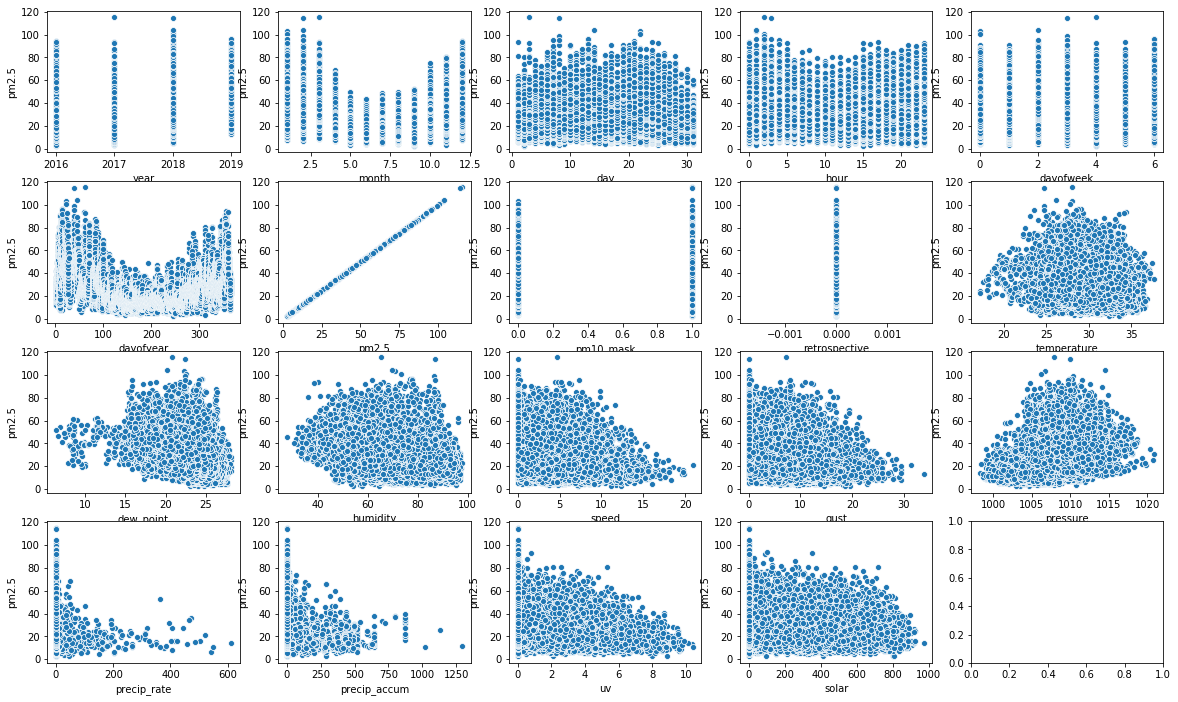

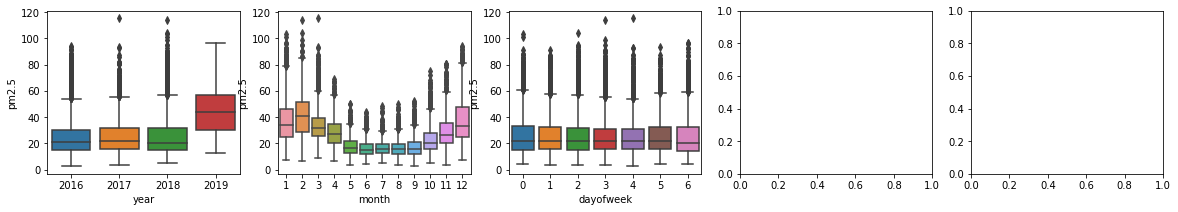

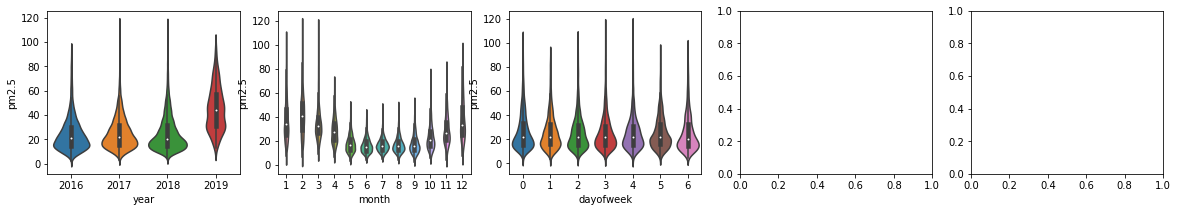

In [41]:
# feature exploration: pm2.5
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
col_object = ['year', 'month', 'dayofweek']
scatterplot(col_number, 'pm2.5', df_data)
boxplot(col_object, 'pm2.5', df_data)
violinplot(col_object, 'pm2.5', df_data)

The exploratory data analysis resulting in,

* **Speed and gust:** The PM2.5 tend to be lower with higher wind speed and wind gust.
* **Precipitation rate and accumulation:** The PM2.5 tend to be lower with higher precipitation rate and accumulation.

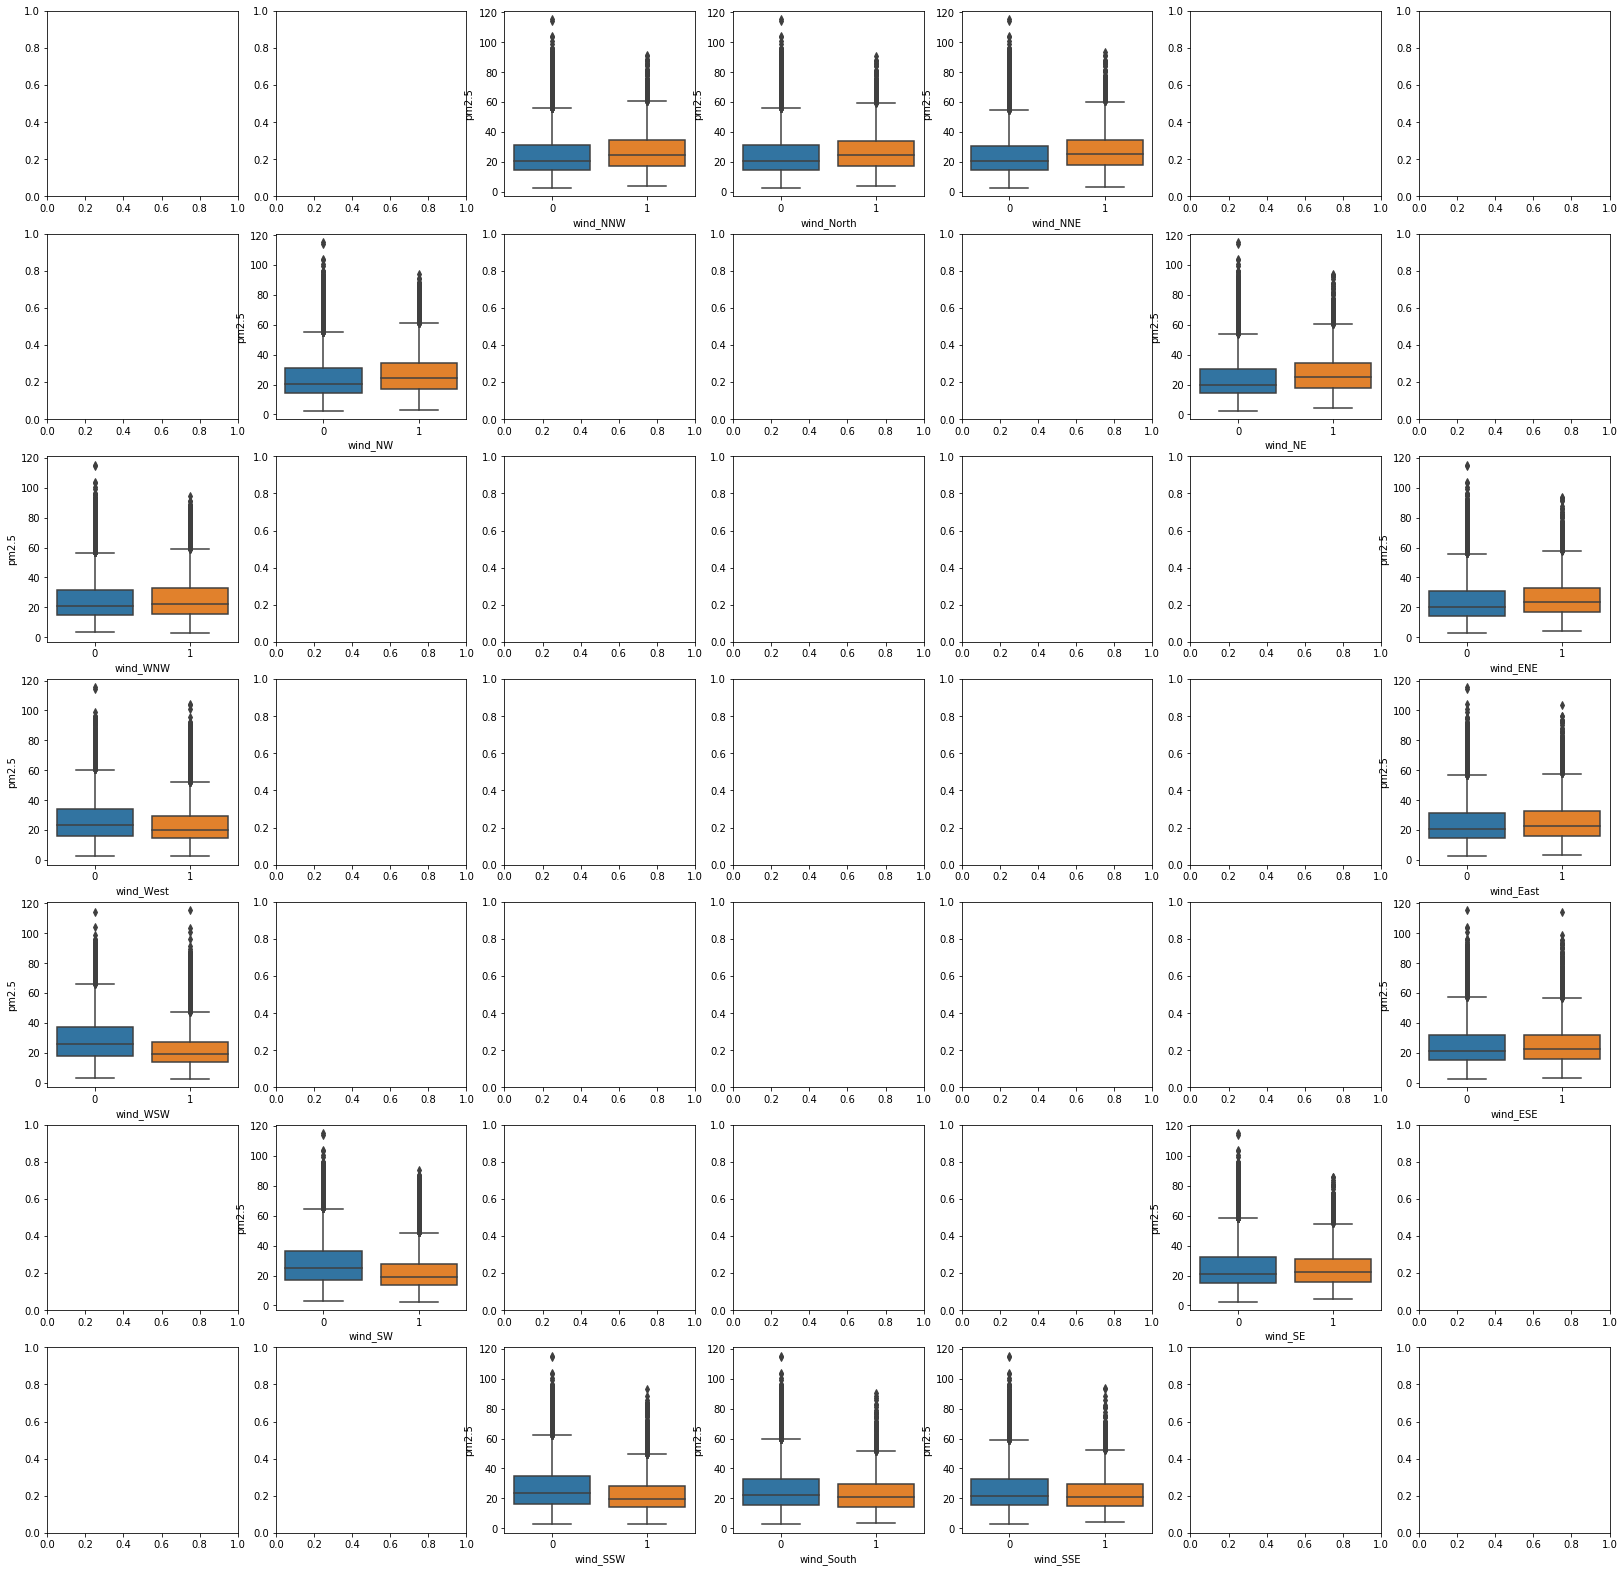

In [42]:
# feature exploration: pm2.5
windclock = {'wind_NW': 8, 'wind_NNW': 2, 'wind_North': 3, 'wind_NNE': 4, 'wind_NE': 12,
             'wind_ENE': 20, 'wind_East': 27, 'wind_ESE': 34,
             'wind_SE': 40, 'wind_SSE': 46, 'wind_South': 45, 'wind_SSW': 44, 'wind_SW': 36,
             'wind_WNW': 14, 'wind_West': 21, 'wind_WSW': 28}
fig, axes = plt.subplots(figsize=(28 , 28), ncols=7, nrows=7)
axes = axes.flatten()
for k, v in windclock.items(): _ = sns.boxplot(x=k, y='pm2.5', data=df_data, ax=axes[v])

The exploratory data analysis resulting in,

* **Wind direction:** The PM2.5 tend to be higher in wind direction WNW through East rotating clockwise and tend to be lower in wind direction ESE through West rotating clockwise.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


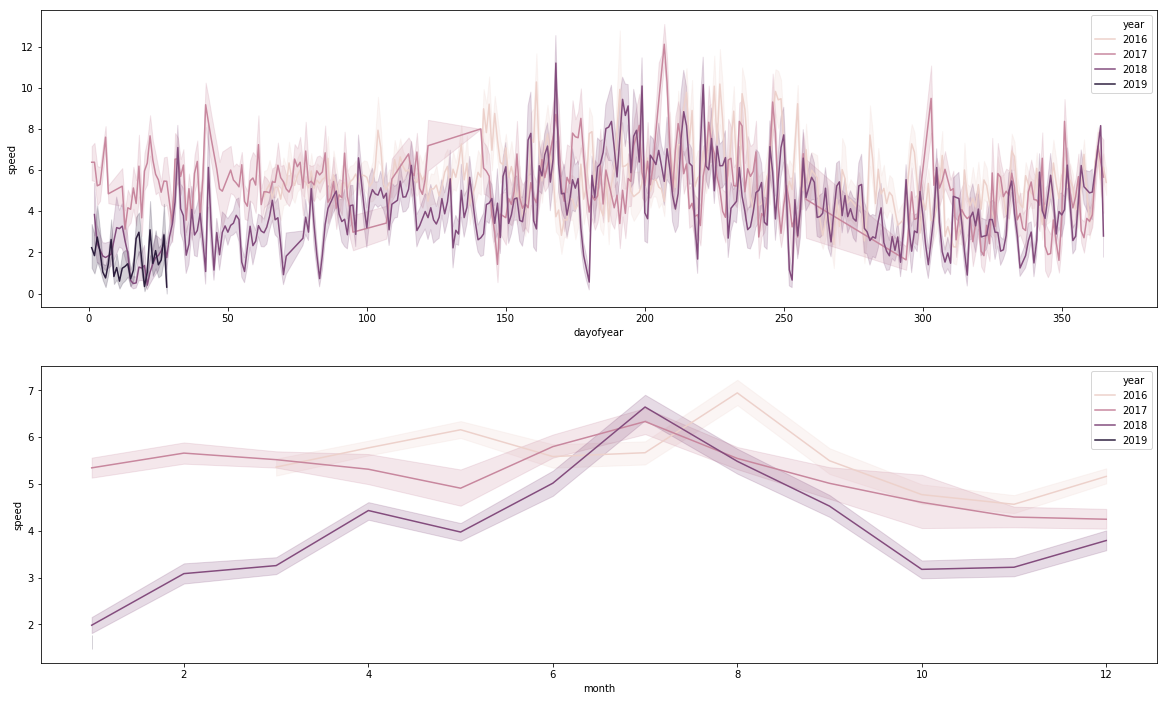

In [43]:
# feature exploration: season wind speed
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='speed', data=df_data, ax=axes[0], hue='year')
_ = sns.lineplot(x='month', y='speed', data=df_data, ax=axes[1], hue='year')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


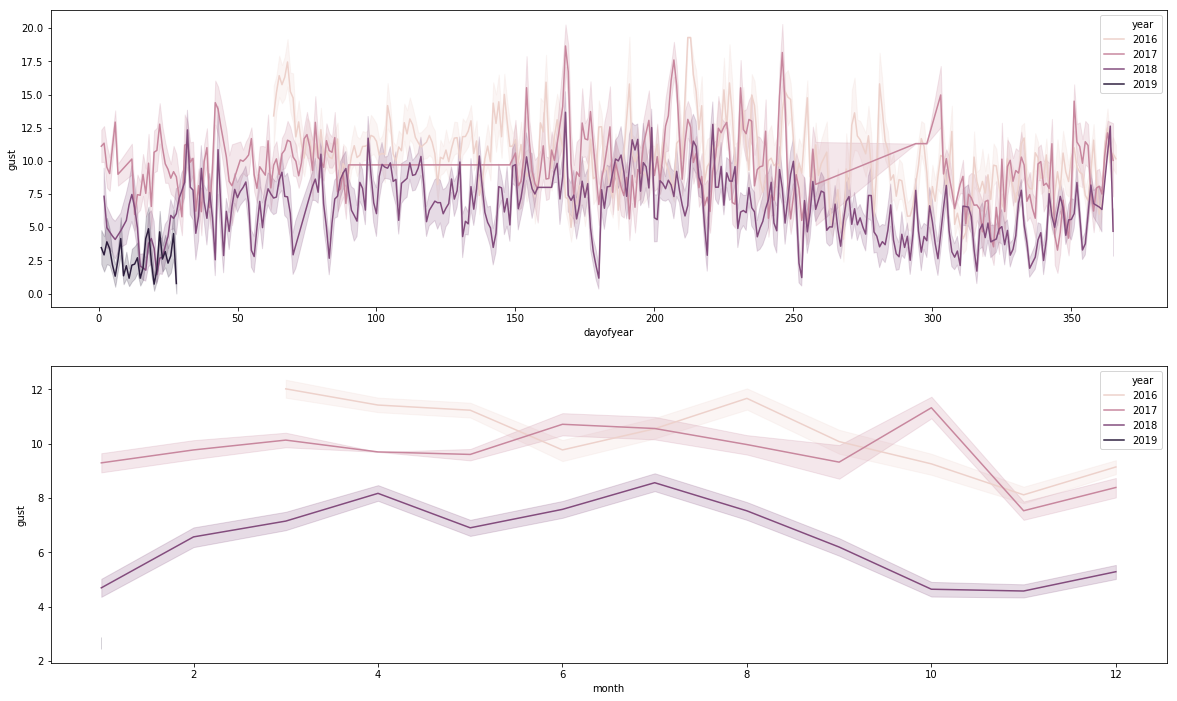

In [44]:
# feature exploration: season wind gust
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='gust', data=df_data, ax=axes[0], hue='year')
_ = sns.lineplot(x='month', y='gust', data=df_data, ax=axes[1], hue='year')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


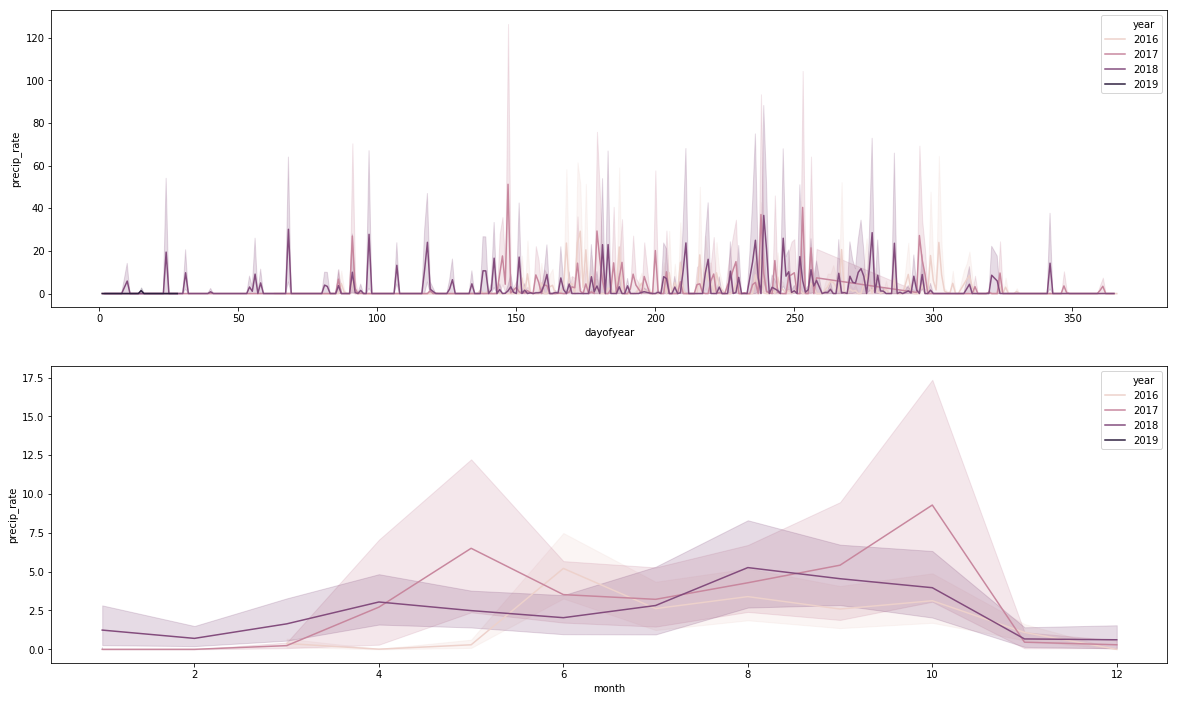

In [45]:
# feature exploration: season precipitation rate
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='precip_rate', data=df_data, ax=axes[0], hue='year')
_ = sns.lineplot(x='month', y='precip_rate', data=df_data, ax=axes[1], hue='year')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


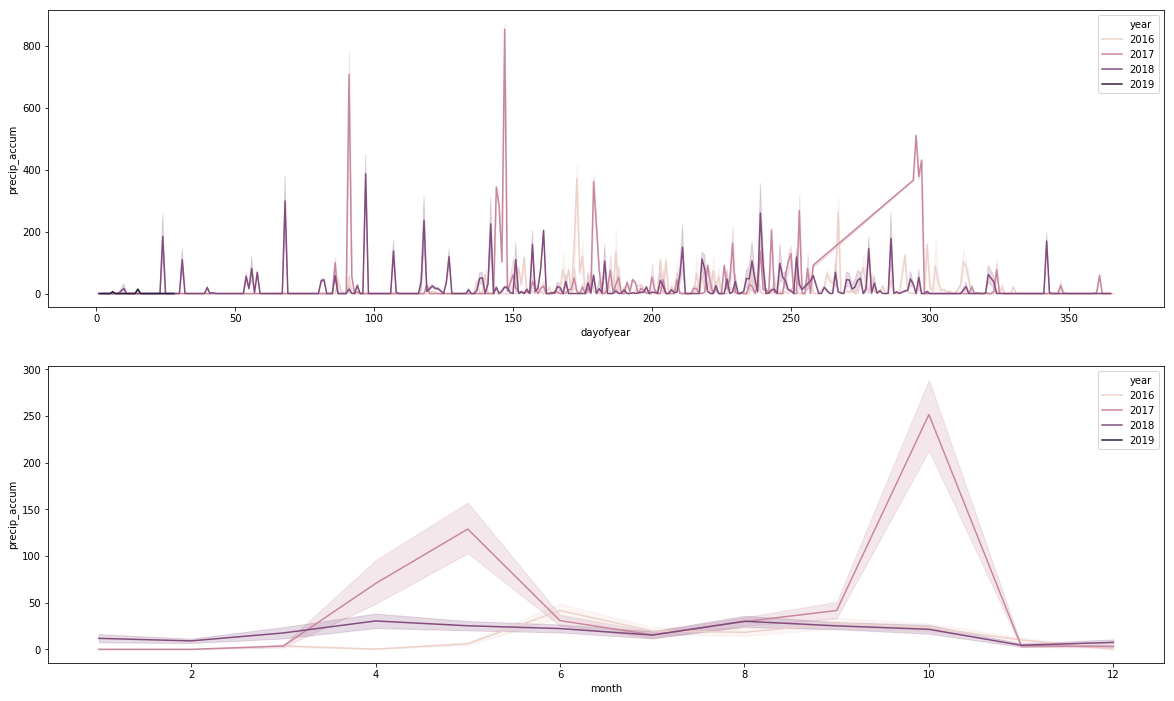

In [46]:
# feature exploration: season precipitation accumulation
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='precip_accum', data=df_data, ax=axes[0], hue='year')
_ = sns.lineplot(x='month', y='precip_accum', data=df_data, ax=axes[1], hue='year')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


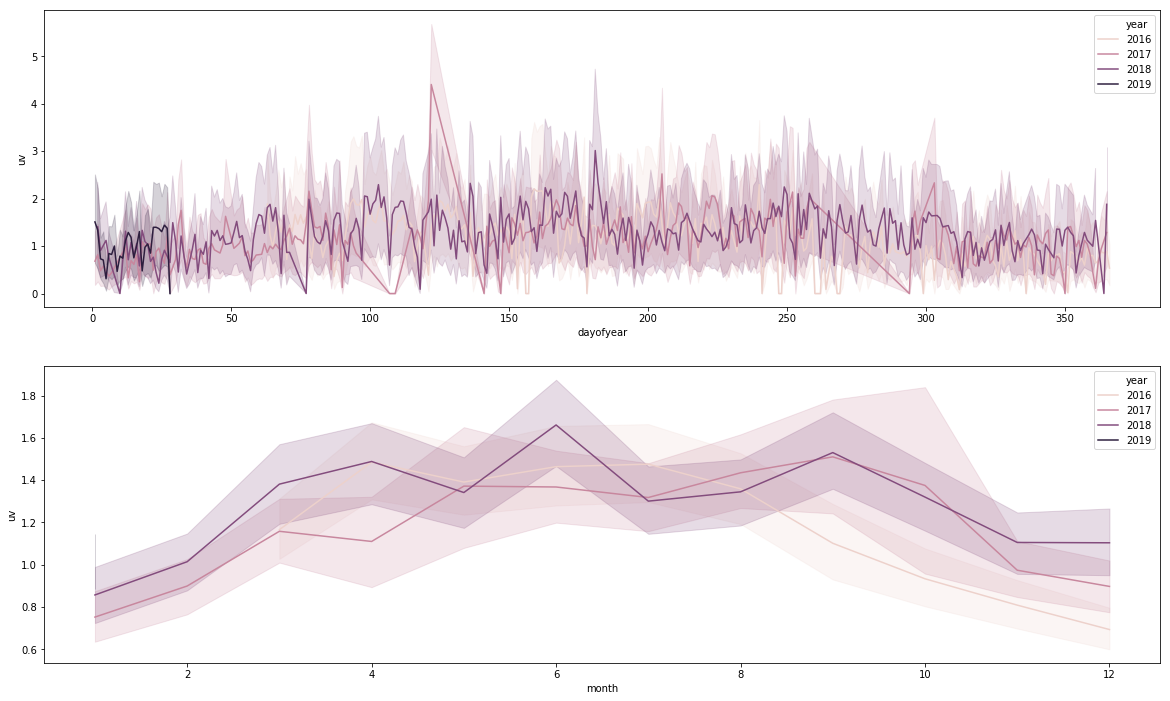

In [47]:
# feature exploration: season uv
fig, axes = plt.subplots(figsize=(20, 12), ncols=1, nrows=2)
axes = axes.flatten()
_ = sns.lineplot(x='dayofyear', y='uv', data=df_data, ax=axes[0], hue='year')
_ = sns.lineplot(x='month', y='uv', data=df_data, ax=axes[1], hue='year')

In [48]:
# feature extraction: rolling temperature
for n in (6, 12, 24, 48, 72): df_data['temperature_sma' + str(n)] = df_data['temperature'].shift(-n).rolling(6, min_periods=6).mean()

In [49]:
# feature extraction: rolling dew_point
for n in (6, 12, 24, 48, 72): df_data['dew_point_sma' + str(n)] = df_data['dew_point'].shift(-n).rolling(6, min_periods=6).mean()

In [50]:
# feature extraction: rolling humidity
for n in (6, 12, 24, 48, 72): df_data['humidity_sma' + str(n)] = df_data['humidity'].shift(-n).rolling(6, min_periods=6).mean()

In [51]:
# feature extraction: rolling speed
for n in (6, 12, 24, 48, 72): df_data['speed_sma' + str(n)] = df_data['speed'].shift(-n).rolling(6, min_periods=6).mean()

In [52]:
# feature extraction: rolling gust
for n in (6, 12, 24, 48, 72): df_data['gust_sma' + str(n)] = df_data['gust'].shift(-n).rolling(6, min_periods=6).mean()

In [53]:
# feature extraction: rolling pressure
for n in (6, 12, 24, 48, 72): df_data['pressure_sma' + str(n)] = df_data['pressure'].shift(-n).rolling(6, min_periods=6).mean()

In [54]:
# feature extraction: rolling precip_rate
for n in (6, 12, 24, 48, 72): df_data['precip_rate_sma' + str(n)] = df_data['precip_rate'].shift(-n).rolling(6, min_periods=6).mean()

In [55]:
# feature extraction: rolling precip_accum
for n in (6, 12, 24, 48, 72): df_data['precip_accum_sma' + str(n)] = df_data['precip_accum'].shift(-n).rolling(6, min_periods=6).mean()

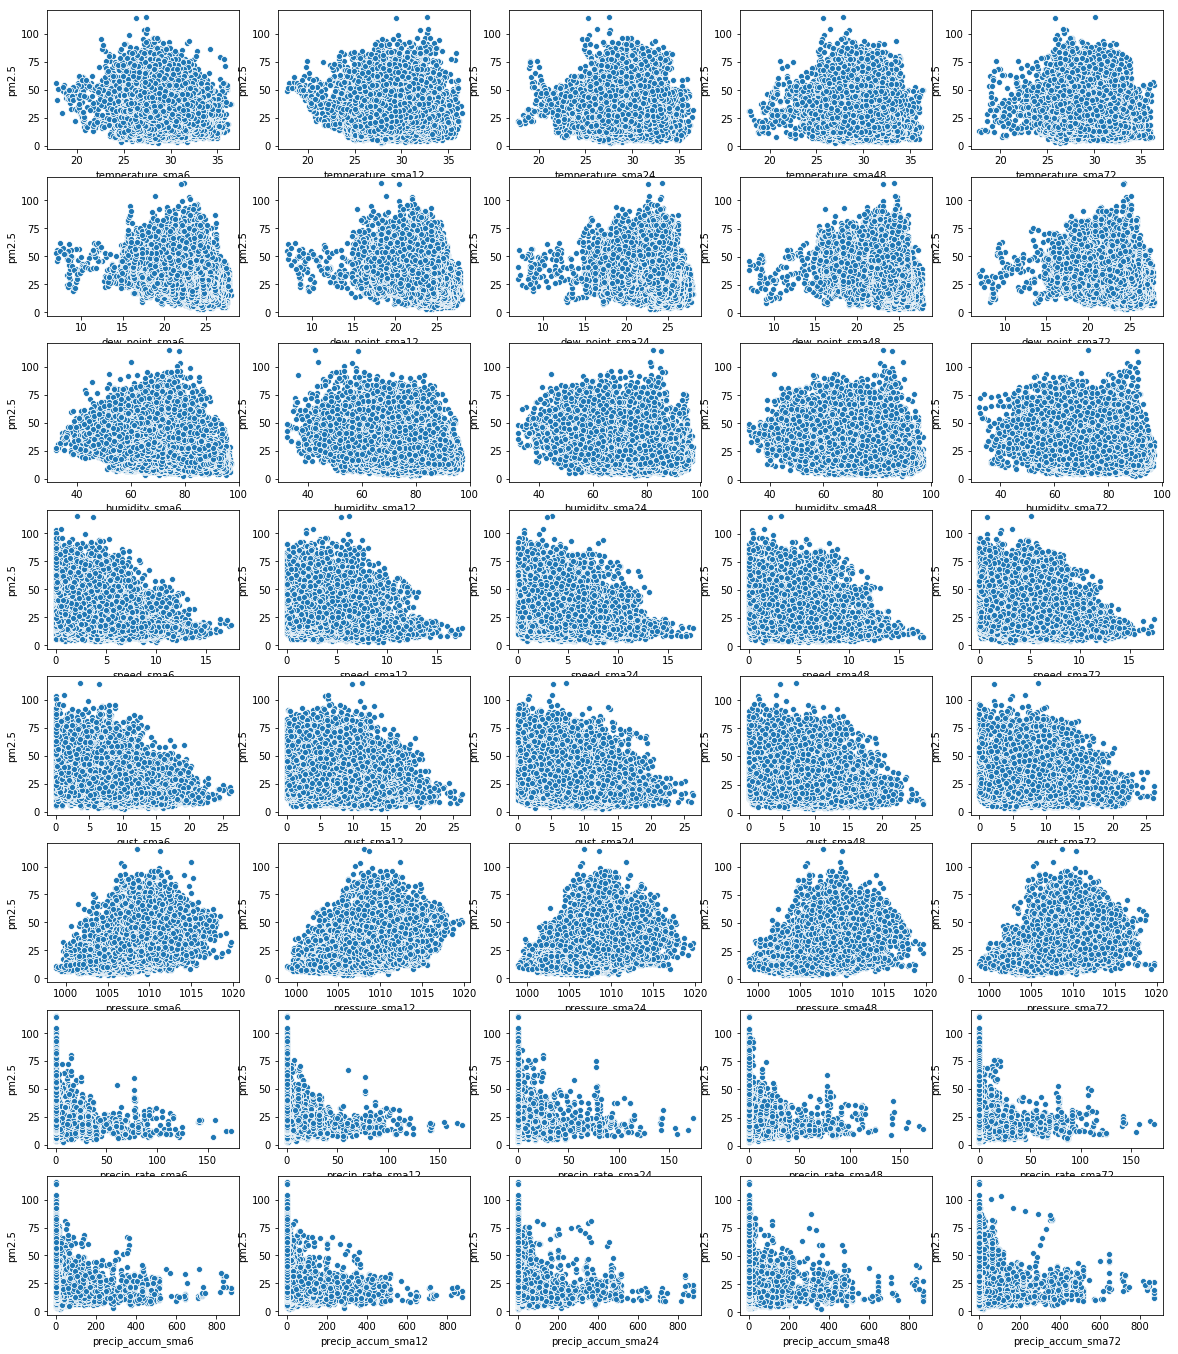

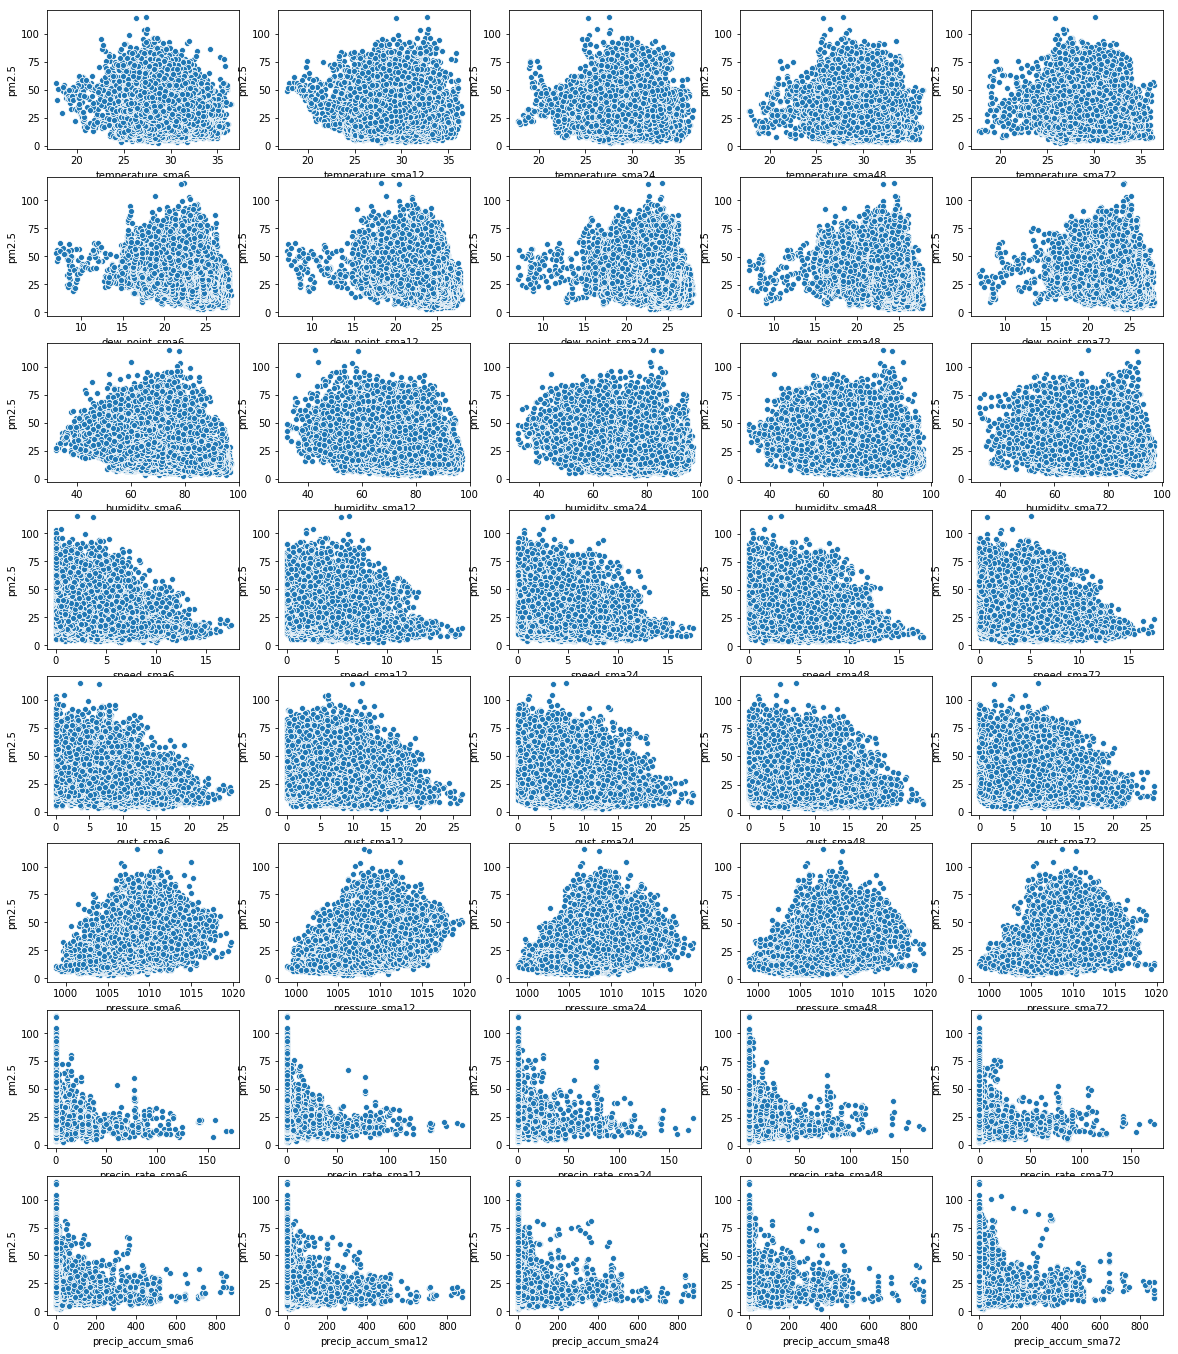

In [56]:
# feature exploration: pm2.5
col_number = [col for col in df_data.select_dtypes(include=['number']).columns if '_sma' in col]
scatterplot(col_number, 'pm2.5', df_data)

The exploratory data analysis resulting in,

* **Backward rolling:** The PM2.5 tend to correlate with the backward rolling in the similar sense as current value of each feature.

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [57]:
# feature extraction: dropna
df_data = df_data.dropna()

In [58]:
# convert dtypes object to numeric for data dataframe
col_convert = ['wind_ENE', 'wind_ESE', 'wind_East', 'wind_NE', 'wind_NNE', 'wind_NNW', 'wind_NW', 'wind_North', 'wind_SE', 'wind_SSE', 'wind_SSW', 'wind_SW', 'wind_South', 'wind_WNW', 'wind_WSW', 'wind_West']
df_data[col_convert] = df_data[col_convert].astype(int)

In [59]:
# describe data dataframe
df_data.describe(include='all')

year         ...          precip_accum_sma72
count  18295.000000         ...                1.829500e+04
mean    2017.148073         ...                1.696666e+01
std        0.893225         ...                5.612902e+01
min     2016.000000         ...                0.000000e+00
25%     2016.000000         ...                3.878379e-14
50%     2017.000000         ...                3.410605e-13
75%     2018.000000         ...                3.425000e+00
max     2019.000000         ...                8.712000e+02

[8 rows x 75 columns]

In [60]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18295 entries, 2016-03-03 21:00:00 to 2019-01-24 21:00:00
Data columns (total 75 columns):
year                  18295 non-null int64
month                 18295 non-null int64
day                   18295 non-null int64
hour                  18295 non-null int64
dayofweek             18295 non-null int64
dayofyear             18295 non-null int64
pm2.5                 18295 non-null float64
pm10_mask             18295 non-null int64
retrospective         18295 non-null int64
temperature           18295 non-null float64
dew_point             18295 non-null float64
humidity              18295 non-null float64
speed                 18295 non-null float64
gust                  18295 non-null float64
pressure              18295 non-null float64
precip_rate           18295 non-null float64
precip_accum          18295 non-null float64
uv                    18295 non-null float64
solar                 18295 non-null float64
wind_East        

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

In [61]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_data.corr()
fig, axes = plt.subplots(figsize=(200, 150))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [62]:
# select all features to evaluate the feature importances
x = df_data.drop(['year', 'dayofyear', 'pm2.5', 'pm10_mask', 'retrospective'], axis=1)
y = np.log1p(df_data['pm2.5'])

In [63]:
# set up lasso regression to find the feature importances
lassoreg = Lasso(alpha=1e-5).fit(x, y)
feat = pd.DataFrame(data=lassoreg.coef_, index=x.columns, columns=['feature_importances']).sort_values(['feature_importances'], ascending=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


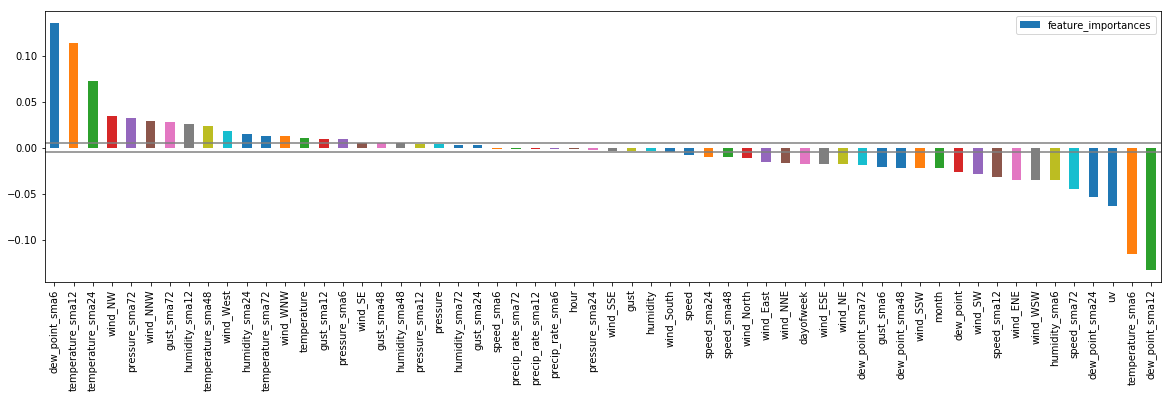

In [64]:
# plot the feature importances
feat[(feat['feature_importances'] < -1e-3) | (feat['feature_importances'] > 1e-3)].dropna().plot(y='feature_importances', figsize=(20, 5), kind='bar')
plt.axhline(-0.005, color="grey")
plt.axhline(0.005, color="grey")

In [65]:
# list feature importances
model_feat = feat[(feat['feature_importances'] < -0.005) | (feat['feature_importances'] > 0.005)].index

In [66]:
# set up random forest regression to find the feature importances
forestreg = RandomForestRegressor(n_estimators=100, random_state=58).fit(x, y)
feat = pd.DataFrame(data=forestreg.feature_importances_, index=x.columns, columns=['feature_importances']).sort_values(['feature_importances'], ascending=False)

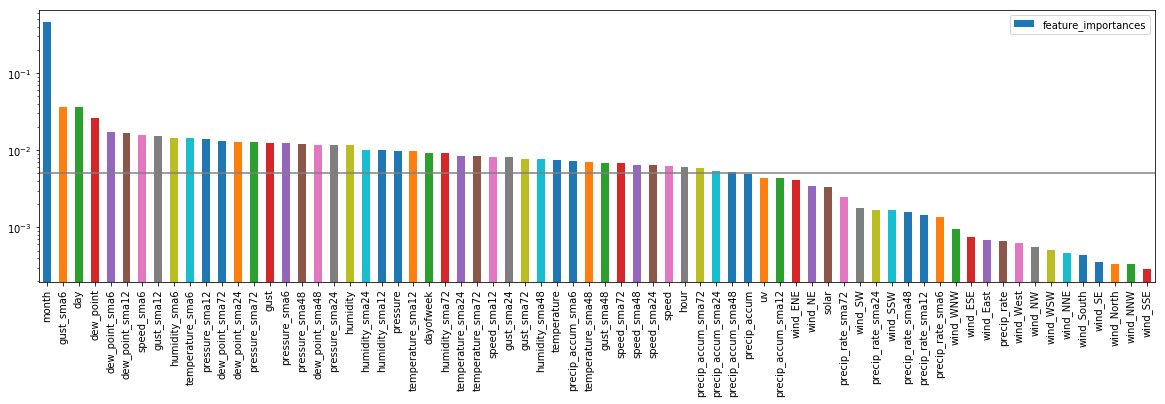

In [67]:
# plot the feature importances
feat.plot(y='feature_importances', figsize=(20, 5), kind='bar', logy=True)
plt.axhline(0.005, color="grey")

In [68]:
# list feature importances
model_feat = feat[feat['feature_importances'] > 0.005].index

In [69]:
# select the important features
x = df_data[model_feat]
y = np.log1p(df_data['pm2.5'])

In [70]:
# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

In [71]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

In [72]:
# linear regression model setup
model_linreg = LinearRegression()

# linear regression model fit
model_linreg.fit(x_train, y_train)

# linear regression model prediction
model_linreg_ypredict = model_linreg.predict(x_validate)

# linear regression model metrics
model_linreg_rmse = mean_squared_error(y_validate, model_linreg_ypredict) ** 0.5
model_linreg_cvscores = np.sqrt(np.abs(cross_val_score(model_linreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('linear regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_linreg_rmse, model_linreg_cvscores.mean(), 2 * model_linreg_cvscores.std()))

linear regression
  root mean squared error: 0.3901, cross validation score: 0.4072 (+/- 0.0844)


In [73]:
# lasso regression model setup
model_lassoreg = Lasso(alpha=0.0001, max_iter=1024)

# lasso regression model fit
model_lassoreg.fit(x_train, y_train)

# lasso regression model prediction
model_lassoreg_ypredict = model_lassoreg.predict(x_validate)

# lasso regression model metrics
model_lassoreg_rmse = mean_squared_error(y_validate, model_lassoreg_ypredict) ** 0.5
model_lassoreg_cvscores = np.sqrt(np.abs(cross_val_score(model_lassoreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('lasso regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_lassoreg_rmse, model_lassoreg_cvscores.mean(), 2 * model_lassoreg_cvscores.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

lasso regression
  root mean squared error: 0.3903, cross validation score: 0.4071 (+/- 0.0847)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [74]:
# ridge regression model setup
model_ridgereg = Ridge(alpha=10)

# ridge regression model fit
model_ridgereg.fit(x_train, y_train)

# ridge regression model prediction
model_ridgereg_ypredict = model_ridgereg.predict(x_validate)

# ridge regression model metrics
model_ridgereg_rmse = mean_squared_error(y_validate, model_ridgereg_ypredict) ** 0.5
model_ridgereg_cvscores = np.sqrt(np.abs(cross_val_score(model_ridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_ridgereg_rmse, model_ridgereg_cvscores.mean(), 2 * model_ridgereg_cvscores.std()))

ridge regression
  root mean squared error: 0.3903, cross validation score: 0.4072 (+/- 0.0843)


In [75]:
# elastic net regression model setup
model_elasticnetreg = ElasticNet(alpha=0.0001, l1_ratio=0.1, max_iter=1024)

# elastic net regression model fit
model_elasticnetreg.fit(x_train, y_train)

# elastic net regression model prediction
model_elasticnetreg_ypredict = model_elasticnetreg.predict(x_validate)

# elastic net regression model metrics
model_elasticnetreg_rmse = mean_squared_error(y_validate, model_elasticnetreg_ypredict) ** 0.5
model_elasticnetreg_cvscores = np.sqrt(np.abs(cross_val_score(model_elasticnetreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('elastic net regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_elasticnetreg_rmse, model_elasticnetreg_cvscores.mean(), 2 * model_elasticnetreg_cvscores.std()))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

elastic net regression
  root mean squared error: 0.3901, cross validation score: 0.4072 (+/- 0.0843)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [76]:
# kernel ridge regression model setup
model_kernelridgereg = KernelRidge(alpha=0.1, kernel='polynomial', degree=2)

# kernel ridge regression model fit
model_kernelridgereg.fit(x_train, y_train)

# kernel ridge regression model prediction
model_kernelridgereg_ypredict = model_kernelridgereg.predict(x_validate)

# kernel ridge regression model metrics
model_kernelridgereg_rmse = mean_squared_error(y_validate, model_kernelridgereg_ypredict) ** 0.5
model_kernelridgereg_cvscores = np.sqrt(np.abs(cross_val_score(model_kernelridgereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('kernel ridge regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_kernelridgereg_rmse, model_kernelridgereg_cvscores.mean(), 2 * model_kernelridgereg_cvscores.std()))

kernel ridge regression
  root mean squared error: 0.3217, cross validation score: 0.4560 (+/- 0.0859)


In [77]:
# decision tree regression model setup
model_treereg = DecisionTreeRegressor(splitter='best', min_samples_split=2000)

# decision tree regression model fit
model_treereg.fit(x_train, y_train)

# decision tree regression model prediction
model_treereg_ypredict = model_treereg.predict(x_validate)

# decision tree regression model metrics
model_treereg_rmse = mean_squared_error(y_validate, model_treereg_ypredict) ** 0.5
model_treereg_cvscores = np.sqrt(np.abs(cross_val_score(model_treereg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('decision tree regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_treereg_rmse, model_treereg_cvscores.mean(), 2 * model_treereg_cvscores.std()))

decision tree regression
  root mean squared error: 0.3662, cross validation score: 0.3969 (+/- 0.0687)


In [78]:
# random forest regression model setup
model_forestreg = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=58)

# random forest regression model fit
model_forestreg.fit(x_train, y_train)

# random forest regression model prediction
model_forestreg_ypredict = model_forestreg.predict(x_validate)

# random forest regression model metrics
model_forestreg_rmse = mean_squared_error(y_validate, model_forestreg_ypredict) ** 0.5
model_forestreg_cvscores = np.sqrt(np.abs(cross_val_score(model_forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestreg_rmse, model_forestreg_cvscores.mean(), 2 * model_forestreg_cvscores.std()))

random forest regression
  root mean squared error: 0.2834, cross validation score: 0.3909 (+/- 0.0756)


In [79]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
model_xgbreg_cvscores = np.sqrt(np.abs(cross_val_score(model_xgbreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('xgboost regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_xgbreg_rmse, model_xgbreg_cvscores.mean(), 2 * model_xgbreg_cvscores.std()))

[0]	validation_0-rmse:2.42261	validation_1-rmse:2.43044


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.072272	validation_1-rmse:0.196449
[200]	validation_0-rmse:0.027869	validation_1-rmse:0.187301
[300]	validation_0-rmse:0.012687	validation_1-rmse:0.185283
[400]	validation_0-rmse:0.00729	validation_1-rmse:0.184688
[500]	validation_0-rmse:0.005116	validation_1-rmse:0.18444
[600]	validation_0-rmse:0.004081	validation_1-rmse:0.184315
[700]	validation_0-rmse:0.003532	validation_1-rmse:0.184248
[800]	validation_0-rmse:0.003191	validation_1-rmse:0.184215
[900]	validation_0-rmse:0.002967	validation_1-rmse:0.184185
[999]	validation_0-rmse:0.00281	validation_1-rmse:0.184162


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


xgboost regression
  root mean squared error: 0.1842, cross validation score: 0.3956 (+/- 0.0681)


> **Supply or submit the results**

Our prediction is ready. Any suggestions to improve our score are welcome.

In [80]:
# model selection
final_model = model_xgbreg

# prepare testing data and compute the observed value
x_test = df_data[model_feat]
x_test = scaler.transform(x_test)
y_test = pd.DataFrame(np.expm1(final_model.predict(x_test)), columns=['pm2.5'], index=df_data.index)

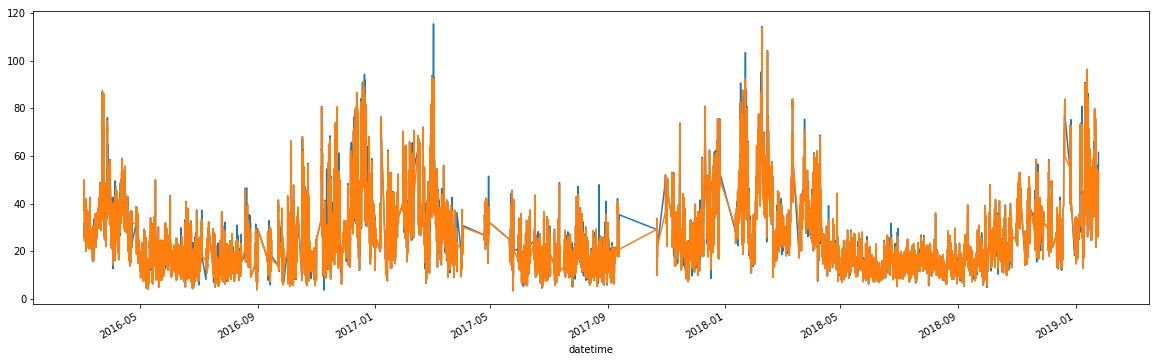

In [81]:
# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = df_data['pm2.5'].plot(ax=axes)
_ = y_test['pm2.5'].plot(ax=axes)

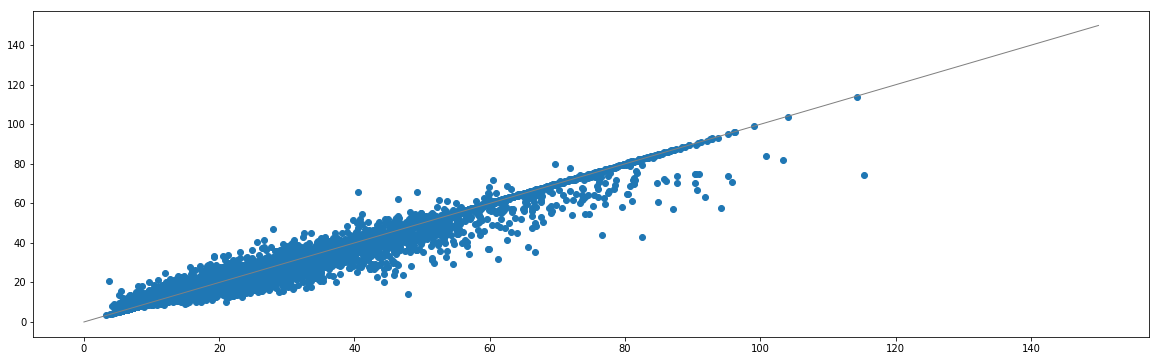

In [82]:
# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(df_data['pm2.5'], y_test['pm2.5'])
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

Many ideas are initiated and it is time to test them all.

* **Month feature only:** This is to test whether how much of the PM2.5 impact from season.

[0]	validation_0-rmse:2.42318	validation_1-rmse:2.43122


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.187714	validation_1-rmse:0.247922
[200]	validation_0-rmse:0.156736	validation_1-rmse:0.245075
xgboost regression
  root mean squared error: 0.2442


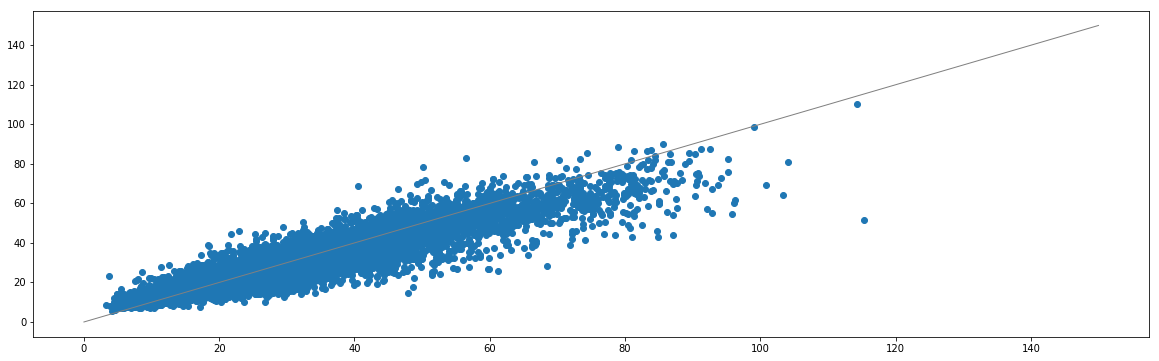

In [83]:
# select the focused features
x = df_data[['month', 'day', 'hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Remove the month feature:** This is to test whether, eliminating the impact from season, how much of the PM2.5 impact from other features e.g. wind speed and wind gust.

[0]	validation_0-rmse:2.42384	validation_1-rmse:2.43192


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.073868	validation_1-rmse:0.225061
[200]	validation_0-rmse:0.027458	validation_1-rmse:0.214667
[300]	validation_0-rmse:0.012686	validation_1-rmse:0.212281
[400]	validation_0-rmse:0.007072	validation_1-rmse:0.211507
[500]	validation_0-rmse:0.00495	validation_1-rmse:0.211236
[600]	validation_0-rmse:0.00397	validation_1-rmse:0.21111
[700]	validation_0-rmse:0.003444	validation_1-rmse:0.211046
[800]	validation_0-rmse:0.003127	validation_1-rmse:0.21101
[900]	validation_0-rmse:0.002918	validation_1-rmse:0.210981
[999]	validation_0-rmse:0.002774	validation_1-rmse:0.210957
xgboost regression
  root mean squared error: 0.2110


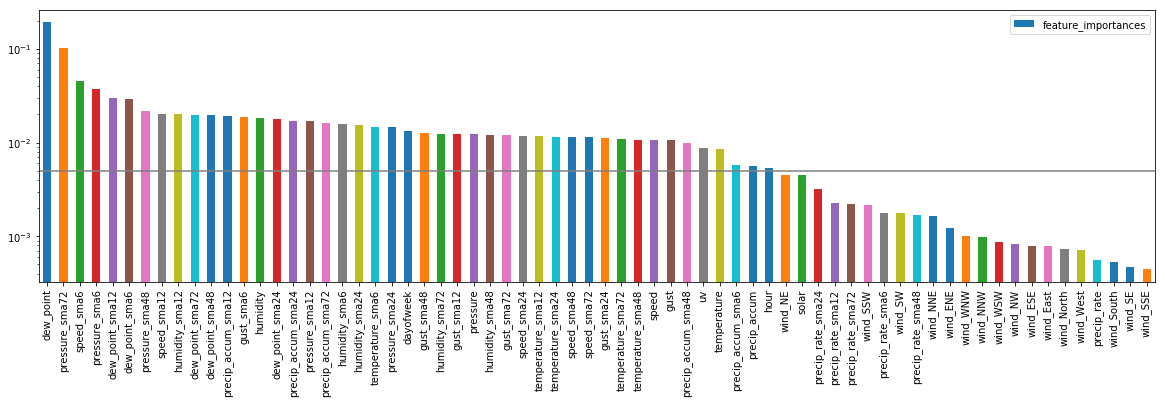

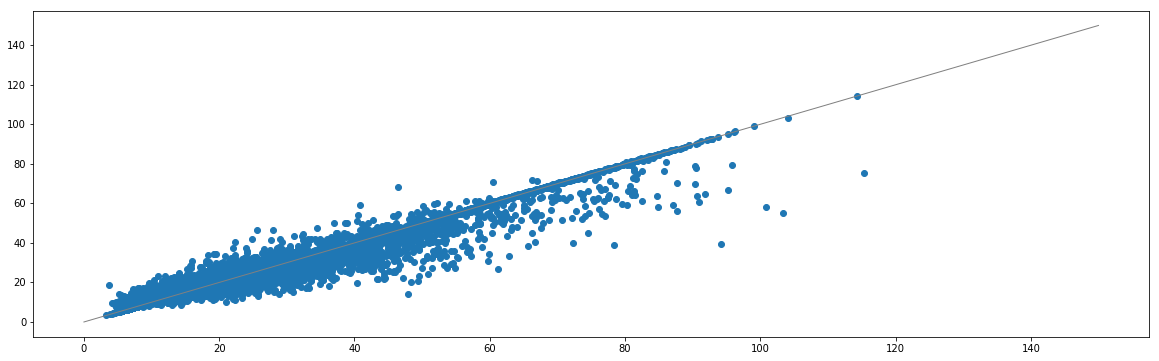

In [84]:
# select all features to evaluate the feature importances
x = df_data.drop(['year', 'month', 'day', 'dayofyear', 'pm2.5', 'pm10_mask', 'retrospective'], axis=1)
y = np.log1p(df_data['pm2.5'])

# set up random forest regression to find the feature importances
forestreg = RandomForestRegressor(n_estimators=100, random_state=58).fit(x, y)
feat = pd.DataFrame(data=forestreg.feature_importances_, index=x.columns, columns=['feature_importances']).sort_values(['feature_importances'], ascending=False)

# plot the feature importances
feat.plot(y='feature_importances', figsize=(20, 5), kind='bar', logy=True)
plt.axhline(0.005, color="grey")

# list feature importances
model_feat = feat[feat['feature_importances'] > 0.005].index

# select the important features
x = df_data[model_feat]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 6 hours feature ahead:** This is to test whether, knowing the current weather condition and seasonal, it can predict PM2.5 for the next 6 hours or not.

[0]	validation_0-rmse:2.42276	validation_1-rmse:2.4307


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.116993	validation_1-rmse:0.235392
[200]	validation_0-rmse:0.064664	validation_1-rmse:0.227226
[300]	validation_0-rmse:0.041807	validation_1-rmse:0.224782
[400]	validation_0-rmse:0.028083	validation_1-rmse:0.223542
[500]	validation_0-rmse:0.019656	validation_1-rmse:0.222947
[600]	validation_0-rmse:0.013929	validation_1-rmse:0.222503
[700]	validation_0-rmse:0.010593	validation_1-rmse:0.222235
[800]	validation_0-rmse:0.008606	validation_1-rmse:0.222058
[900]	validation_0-rmse:0.007433	validation_1-rmse:0.221962
[999]	validation_0-rmse:0.006678	validation_1-rmse:0.221872
xgboost regression
  root mean squared error: 0.2219


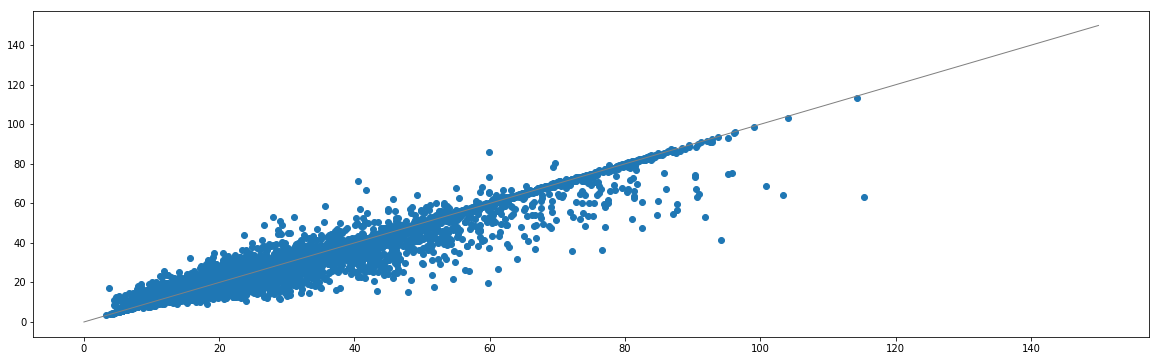

In [85]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma6')] + ['month', 'hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 12 hours feature ahead:** This is to test whether, knowing the current weather condition and seasonal, it can predict PM2.5 for the next 12 hours or not.

[0]	validation_0-rmse:2.42293	validation_1-rmse:2.43083


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.125377	validation_1-rmse:0.238507
[200]	validation_0-rmse:0.072114	validation_1-rmse:0.230075
[300]	validation_0-rmse:0.047744	validation_1-rmse:0.227378
[400]	validation_0-rmse:0.032307	validation_1-rmse:0.225983
[500]	validation_0-rmse:0.021966	validation_1-rmse:0.225112
[600]	validation_0-rmse:0.015677	validation_1-rmse:0.224619
[700]	validation_0-rmse:0.011677	validation_1-rmse:0.22433
[800]	validation_0-rmse:0.009276	validation_1-rmse:0.224172
[900]	validation_0-rmse:0.007892	validation_1-rmse:0.224071
[999]	validation_0-rmse:0.007022	validation_1-rmse:0.223993
xgboost regression
  root mean squared error: 0.2240


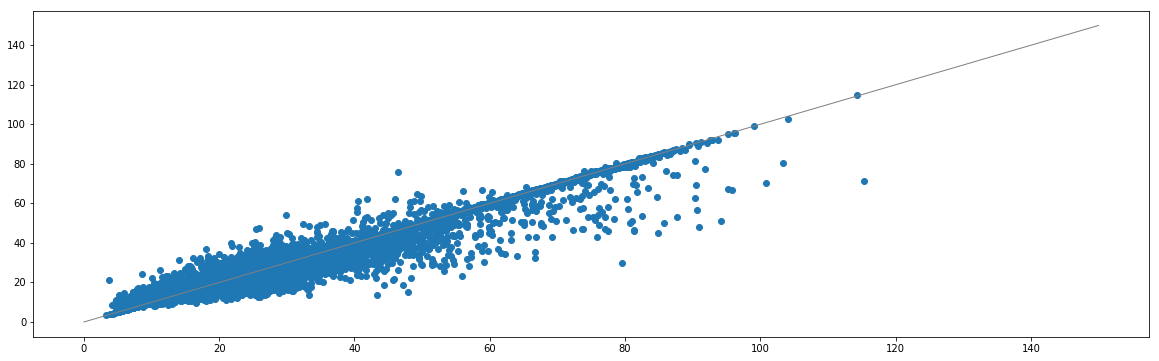

In [86]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma12')] + ['month', 'hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 1 day feature ahead:** This is to test whether, knowing the current weather condition and seasonal, it can predict PM2.5 for the next day or not.

[0]	validation_0-rmse:2.42302	validation_1-rmse:2.43119


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.128882	validation_1-rmse:0.24551
[200]	validation_0-rmse:0.073139	validation_1-rmse:0.235599
[300]	validation_0-rmse:0.048853	validation_1-rmse:0.233709
[400]	validation_0-rmse:0.032607	validation_1-rmse:0.232458
[500]	validation_0-rmse:0.022186	validation_1-rmse:0.231531
[600]	validation_0-rmse:0.015445	validation_1-rmse:0.231033
[700]	validation_0-rmse:0.011503	validation_1-rmse:0.230672
[800]	validation_0-rmse:0.009146	validation_1-rmse:0.230473
[900]	validation_0-rmse:0.007767	validation_1-rmse:0.230342
[999]	validation_0-rmse:0.006935	validation_1-rmse:0.230254
xgboost regression
  root mean squared error: 0.2303


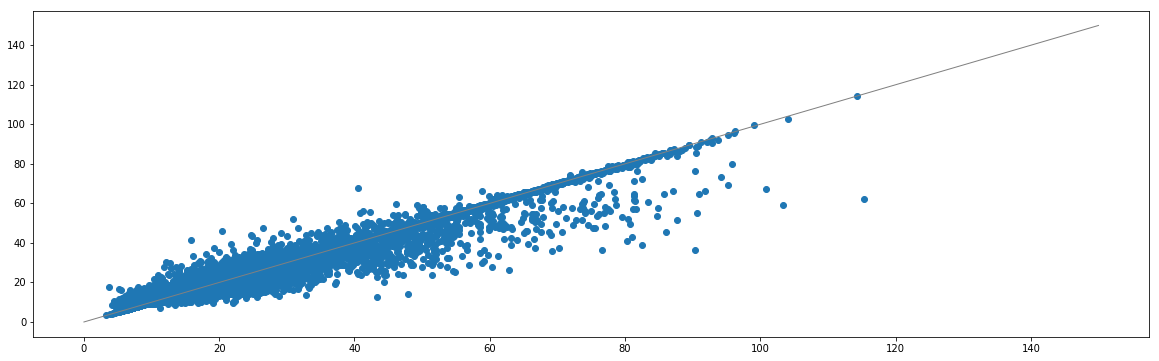

In [87]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma24')] + ['month', 'hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 2 days feature ahead:** This is to test whether, knowing the current weather condition and seasonal, it can predict PM2.5 for the next 2 days or not.

[0]	validation_0-rmse:2.42309	validation_1-rmse:2.43117


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.136649	validation_1-rmse:0.247835
[200]	validation_0-rmse:0.079012	validation_1-rmse:0.238338
[300]	validation_0-rmse:0.051062	validation_1-rmse:0.235681
[400]	validation_0-rmse:0.033483	validation_1-rmse:0.234052
[500]	validation_0-rmse:0.02278	validation_1-rmse:0.233063
[600]	validation_0-rmse:0.01575	validation_1-rmse:0.232414
[700]	validation_0-rmse:0.011676	validation_1-rmse:0.232048
[800]	validation_0-rmse:0.009254	validation_1-rmse:0.231836
[900]	validation_0-rmse:0.007826	validation_1-rmse:0.231683
[999]	validation_0-rmse:0.006962	validation_1-rmse:0.23161
xgboost regression
  root mean squared error: 0.2316


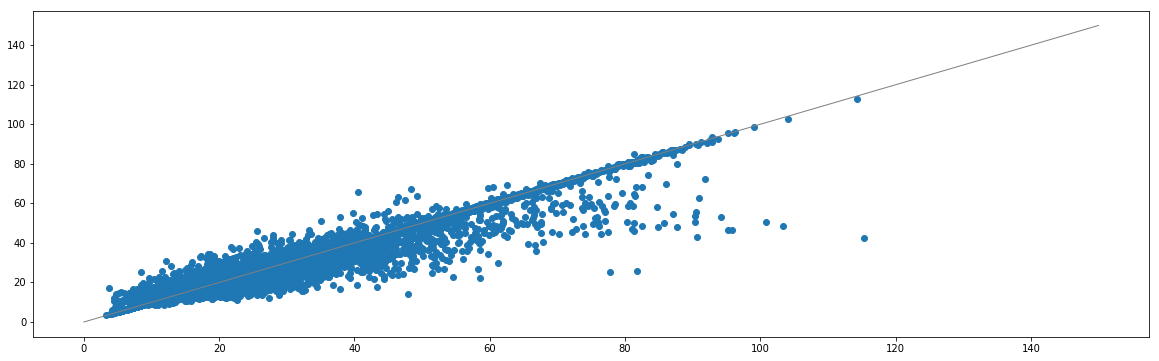

In [88]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma48')] + ['month', 'hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 3 days feature ahead:** This is to test whether, knowing the current weather condition and seasonal, it can predict PM2.5 for the next 3 days or not.

[0]	validation_0-rmse:2.42317	validation_1-rmse:2.43126


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.126064	validation_1-rmse:0.249476
[200]	validation_0-rmse:0.074623	validation_1-rmse:0.241104
[300]	validation_0-rmse:0.047573	validation_1-rmse:0.238077
[400]	validation_0-rmse:0.031863	validation_1-rmse:0.236729
[500]	validation_0-rmse:0.021896	validation_1-rmse:0.235941
[600]	validation_0-rmse:0.015754	validation_1-rmse:0.235525
[700]	validation_0-rmse:0.011644	validation_1-rmse:0.235213
[800]	validation_0-rmse:0.009247	validation_1-rmse:0.235003
[900]	validation_0-rmse:0.007903	validation_1-rmse:0.234883
[999]	validation_0-rmse:0.007047	validation_1-rmse:0.234806
xgboost regression
  root mean squared error: 0.2348


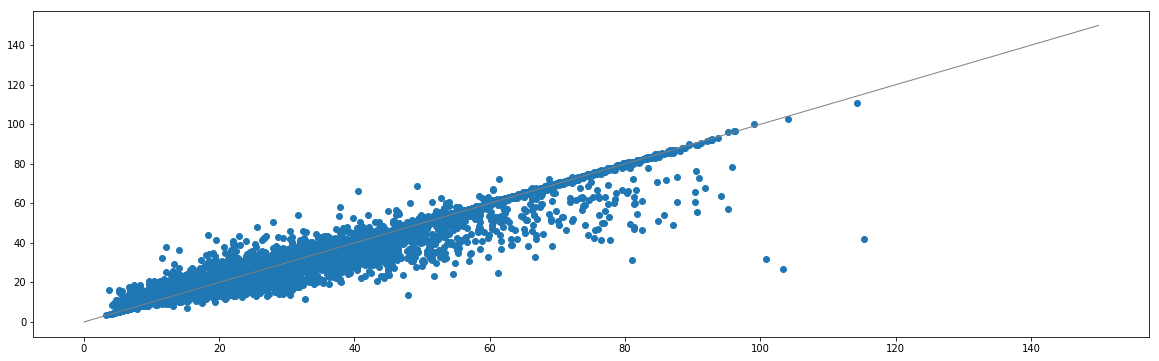

In [89]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma72')] + ['month', 'hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 6 hours feature ahead:** This is to test whether, knowing the current weather condition, it can predict PM2.5 for the next 6 hours or not.

[0]	validation_0-rmse:2.42449	validation_1-rmse:2.43211


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.13595	validation_1-rmse:0.269474
[200]	validation_0-rmse:0.083748	validation_1-rmse:0.261874
[300]	validation_0-rmse:0.053235	validation_1-rmse:0.258707
[400]	validation_0-rmse:0.036335	validation_1-rmse:0.257355
[500]	validation_0-rmse:0.024111	validation_1-rmse:0.255943
[600]	validation_0-rmse:0.01696	validation_1-rmse:0.255289
[700]	validation_0-rmse:0.012329	validation_1-rmse:0.254933
[800]	validation_0-rmse:0.009549	validation_1-rmse:0.254727
[900]	validation_0-rmse:0.007989	validation_1-rmse:0.254578
[999]	validation_0-rmse:0.007057	validation_1-rmse:0.254481
xgboost regression
  root mean squared error: 0.2545


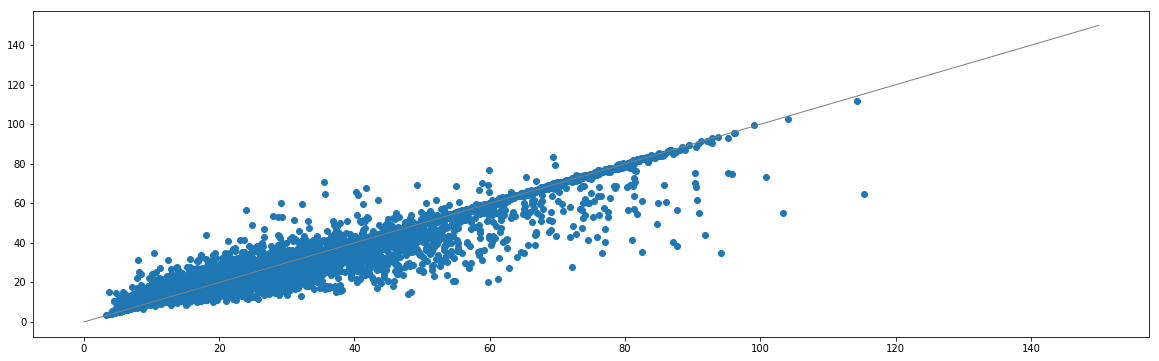

In [90]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma6')] + ['hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 12 hours feature ahead:** This is to test whether, knowing the current weather condition, it can predict PM2.5 for the next 12 hours or not.

[0]	validation_0-rmse:2.42448	validation_1-rmse:2.43235


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.140097	validation_1-rmse:0.274438
[200]	validation_0-rmse:0.086107	validation_1-rmse:0.265746
[300]	validation_0-rmse:0.055003	validation_1-rmse:0.262691
[400]	validation_0-rmse:0.036977	validation_1-rmse:0.261061
[500]	validation_0-rmse:0.024821	validation_1-rmse:0.260184
[600]	validation_0-rmse:0.017433	validation_1-rmse:0.259619
[700]	validation_0-rmse:0.012375	validation_1-rmse:0.259093
[800]	validation_0-rmse:0.009605	validation_1-rmse:0.258865
[900]	validation_0-rmse:0.008035	validation_1-rmse:0.258741
[999]	validation_0-rmse:0.007071	validation_1-rmse:0.258648
xgboost regression
  root mean squared error: 0.2586


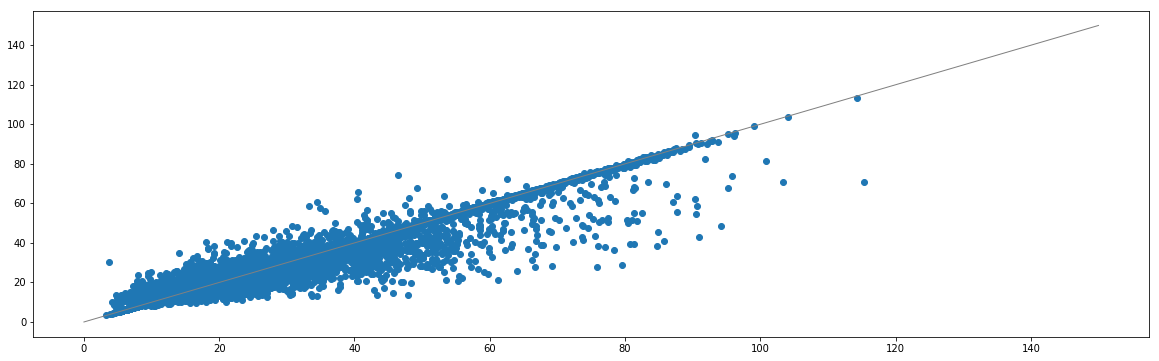

In [91]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma12')] + ['hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 1 day feature ahead:** This is to test whether, knowing the current weather condition, it can predict PM2.5 for the next day or not.

[0]	validation_0-rmse:2.42488	validation_1-rmse:2.43289


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.139553	validation_1-rmse:0.277089
[200]	validation_0-rmse:0.083148	validation_1-rmse:0.267839
[300]	validation_0-rmse:0.053841	validation_1-rmse:0.265
[400]	validation_0-rmse:0.03556	validation_1-rmse:0.263328
[500]	validation_0-rmse:0.024196	validation_1-rmse:0.262551
[600]	validation_0-rmse:0.016869	validation_1-rmse:0.261966
[700]	validation_0-rmse:0.012078	validation_1-rmse:0.261595
[800]	validation_0-rmse:0.009464	validation_1-rmse:0.261392
[900]	validation_0-rmse:0.007913	validation_1-rmse:0.261279
[999]	validation_0-rmse:0.006988	validation_1-rmse:0.261195
xgboost regression
  root mean squared error: 0.2612


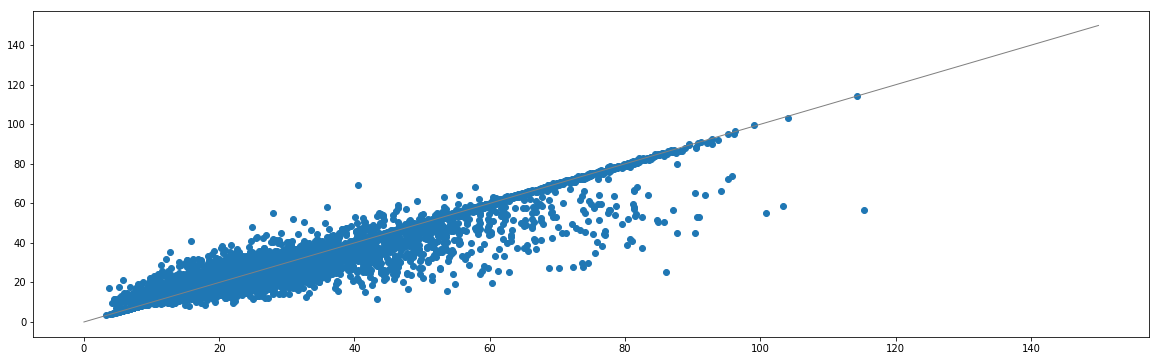

In [92]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma24')] + ['hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 2 days feature ahead:** This is to test whether, knowing the current weather condition, it can predict PM2.5 for the next 2 days or not.

[0]	validation_0-rmse:2.42495	validation_1-rmse:2.43288


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.141352	validation_1-rmse:0.282775
[200]	validation_0-rmse:0.08432	validation_1-rmse:0.272974
[300]	validation_0-rmse:0.054875	validation_1-rmse:0.270221
[400]	validation_0-rmse:0.037394	validation_1-rmse:0.268369
[500]	validation_0-rmse:0.025362	validation_1-rmse:0.267282
[600]	validation_0-rmse:0.01739	validation_1-rmse:0.26657
[700]	validation_0-rmse:0.012595	validation_1-rmse:0.266157
[800]	validation_0-rmse:0.00976	validation_1-rmse:0.265877
[900]	validation_0-rmse:0.008099	validation_1-rmse:0.265749
[999]	validation_0-rmse:0.00712	validation_1-rmse:0.265635
xgboost regression
  root mean squared error: 0.2656


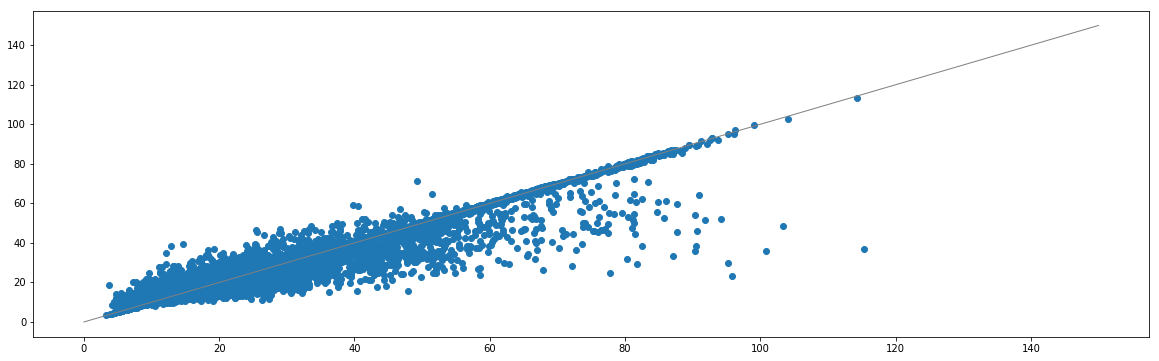

In [93]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma48')] + ['hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)

* **Forecast based on 3 days feature ahead:** This is to test whether, knowing the current weather condition, it can predict PM2.5 for the next 3 days or not.

[0]	validation_0-rmse:2.42506	validation_1-rmse:2.43311


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[100]	validation_0-rmse:0.137814	validation_1-rmse:0.285923
[200]	validation_0-rmse:0.084204	validation_1-rmse:0.275751
[300]	validation_0-rmse:0.055347	validation_1-rmse:0.272019
[400]	validation_0-rmse:0.03647	validation_1-rmse:0.270506
[500]	validation_0-rmse:0.024366	validation_1-rmse:0.26951
[600]	validation_0-rmse:0.017034	validation_1-rmse:0.269017
[700]	validation_0-rmse:0.012198	validation_1-rmse:0.268653
[800]	validation_0-rmse:0.009458	validation_1-rmse:0.268396
[900]	validation_0-rmse:0.0079	validation_1-rmse:0.268216
[999]	validation_0-rmse:0.007028	validation_1-rmse:0.268129
xgboost regression
  root mean squared error: 0.2681


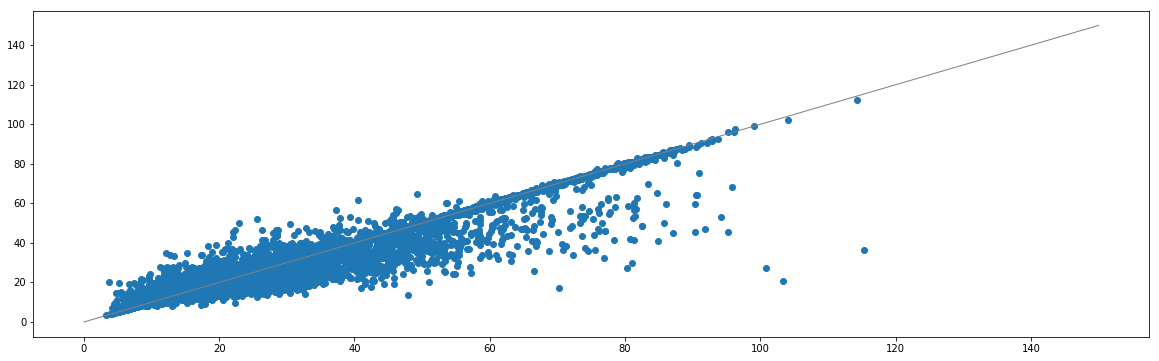

In [94]:
# select the focused features
x = df_data[[col for col in df_data.columns if col.endswith('_sma72')] + ['hour', 'dayofweek']]
y = np.log1p(df_data['pm2.5'])

# create scaler to the features
scaler = RobustScaler()
x = scaler.fit_transform(x)

# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=1000, objective='reg:linear', booster='gbtree', gamma=0, subsample=0.9, colsample_bytree=0.9, reg_alpha=0.1, reg_lambda=0.9, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=100, verbose=False, callbacks=[xgb.callback.print_evaluation(period=100)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

# prediction exploration: pm2.5
fig, axes = plt.subplots(figsize=(20, 6))
_ = plt.scatter(np.expm1(y), np.expm1(model_xgbreg.predict(x)))
_ = plt.plot([0, 150], [0, 150], color='grey', linewidth=1)